## Multi-Armed Bandits: Evaluate multiple system changes while maximizing business metrics

In [659]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from e4e import E4E

e4e = E4E(chapter=3)

### Epsilon-greedy: Account for the impact of evaluation on business metrics

#### A/B testing as a baseline

In a typical A/B testing system, we first determine the number of data points needed, collect the data and analyze the result to decide to accept the alternate option (B) or to keep the default (A). When the experiment data as a whole is analyzed, the value of the business metric will be between the expected values of option A and option B. Regret is the difference in the expected business metric of the optimal option and the business metric of the experimentation data. If option B has a business metric of 0.07, option A has a business metric of 0.05, then A/B test experimentation data will have an overall business metric of 0.06, and so the regret is 0.07 - 0.06 = 0.010.

In [660]:
# Simulate measurement of click on an ad
def measure_click(ctr):                     # with probability ctr, return 1 indicating user clicked ad
    return 1 if np.random.uniform(0,1) < ctr else 0 # generate data for a specifiec click through rate

def measure_a():                            # System version A has ctr (prob of clicking) of 0.005 ie 0.5%
    return measure_click(ctr = 0.005)

def measure_b():                            # System version B has ctr (prob of clicking) of 0.007 ie 0.7%
    return measure_click(ctr=0.007)

In [661]:
# Design an A/B test
def design_ab_test():
    def pilot_study(num_pilot_measurements):    
        clicked_pre_a = np.array([measure_a() for _ in range(num_pilot_measurements)]) # pilot study A
        clicked_pre_b = np.array([measure_b() for _ in range(num_pilot_measurements)]) # pilot study B
        sd_1 = np.sqrt(clicked_pre_a.std()**2 + clicked_pre_b.std()**2) # standard deviation of delta
        return sd_1     
    
    sd_1 = pilot_study(1000)    # run a pilot study to measure standard deviation of delta
    prac_sig = 0.001            # practical significance level of 0.001
    num_ind = (2.48 * sd_1 / prac_sig) ** 2     # calculate number of individual measurements
    return int(num_ind)

In [662]:
np.random.seed(17)
num_ind = design_ab_test()
num_ind

91561

In [663]:
# Simulate a run of an A/B test
def run_ab_test(num_ind):
    clicked_a = []
    clicked_b = []
    for n in range(num_ind):
        # Randomize between A and B
        if np.random.uniform(0,1) < 0.5:        # choose A or B with probability of 0.5, Randomization step
            clicked = measure_a()               # Run A, taking individual measurement
            clicked_a.append(clicked)           # Log individual measurement for later analysis
        else:
            clicked = measure_b()               # Run B, taking individual measurement
            clicked_b.append(clicked)           # Log individual measurement for later analysis

    clicked_a = np.array(clicked_a)             # convert individual measurements A/B into ndarrays
    clicked_b = np.array(clicked_b)

    return clicked_a, clicked_b

In [664]:
# Analyze the A/B test data
def analyze_a_b_test(clicked_a, clicked_b):
    mean_a = clicked_a.mean()                   # aggregate measurement, mean click rates 
    mean_b = clicked_b.mean()
    std_a = clicked_a.std()                     # standard deviation of individual measurement
    std_b = clicked_b.std()
    m = mean_b - mean_a                         # delta, if positive new model b has ctr
    se = np.sqrt( (std_a ** 2 + std_b**2) / num_ind)        # standard error of delta
    z = m / se                                  # z-score
    return z

In [665]:
# Steps of A/B testing: Design, Measure, Analyze
np.random.seed(17)
num_ind = design_ab_test()                      # Step 1: Design, determine number of experiments needed
clicked_a, clicked_b = run_ab_test(num_ind)     # Step 2: Measure, run the A/B test
z = analyze_a_b_test(clicked_a, clicked_b)      # Step 3: Analyze, determine the z-score of the effect 
print(num_ind, np.round(z,2))       # we accept change if z > 1.64 (since here we want higher ctr)

91561 2.95


In [666]:
# Trace the CTR as the A/B test runs
def ab_test(num_ind):
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0

    ctr_vs_n = []
    ctr_a = []
    ctr_b = []
    for _ in range(num_ind):                    # total number of individual measurements
        if np.random.uniform(0,1) < 0.5:        # randomization step to choose model a/b with equal probability
            clicked = measure_a()               # use model a to choose ad to send to user
            sum_a += clicked                    # track number of model a ads clicked by users
            num_a += 1                          # track number of ads sent from model a
        else:
            clicked = measure_b()               # use model b to choose ad to send to user
            sum_b += clicked                    # track number of model b ads clicked by users
            num_b += 1                          # track number of ads sent from model b

        sum_clicks += clicked                   # total number of ads clicked by users
        num_ads += 1                            # total number of ads sent to users

        if num_a > 0:                          # if model a has sent at least one ad (for overall ctr)
            ctr_a.append(sum_a / num_a)         # calculate and store click through rate from model a
        if num_b > 0:                           # if model b has sent at least one ad (for overall ctr)
            ctr_b.append(sum_b / num_b)         # calculate and store click through rate from model b
        if num_ads > 0:                         # if either model has sent at least one ad (for overall ctr)
            ctr_vs_n.append(sum_clicks / num_ads)   # calculate and store overall ctr achieved so far
        
    return ctr_vs_n, ctr_a, ctr_b

In [667]:
np.random.seed(17)
ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)

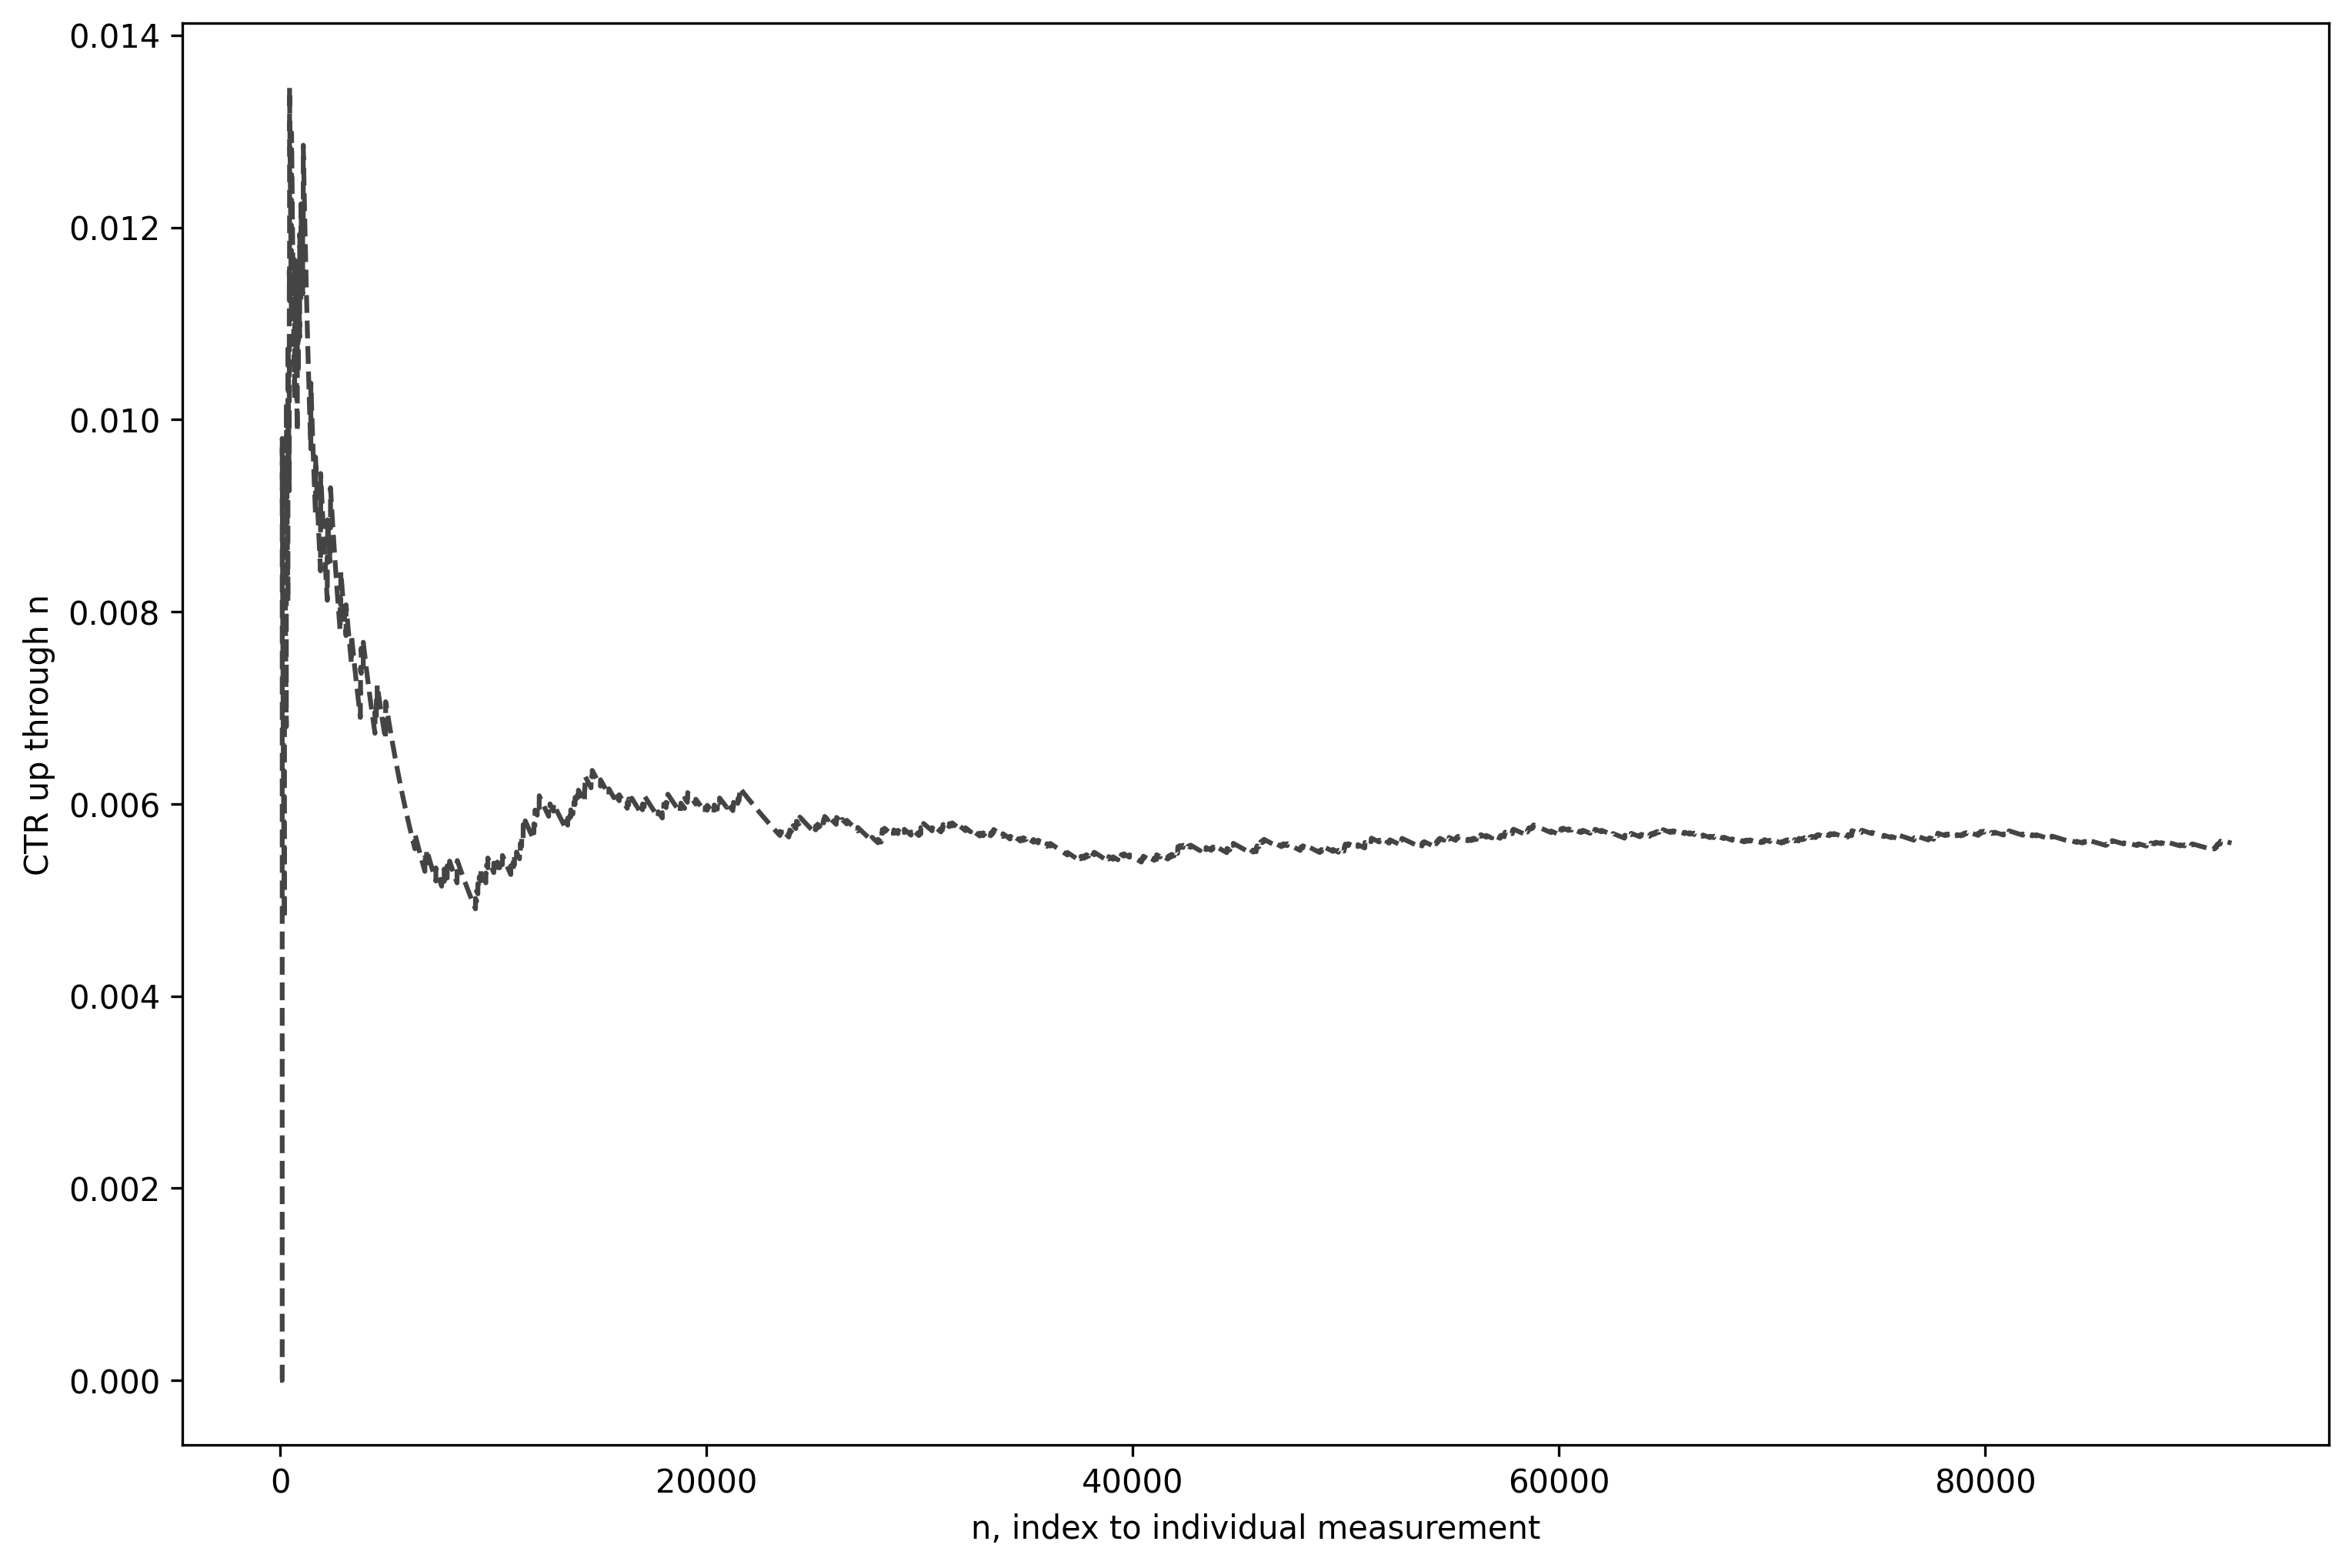

In [668]:
plt.figure(figsize=(12,8))
plt.plot(ctr_vs_n, '--', color=e4e.color_1)
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n')
plt.show()

0.0051003727195448895 0.006085547918217241


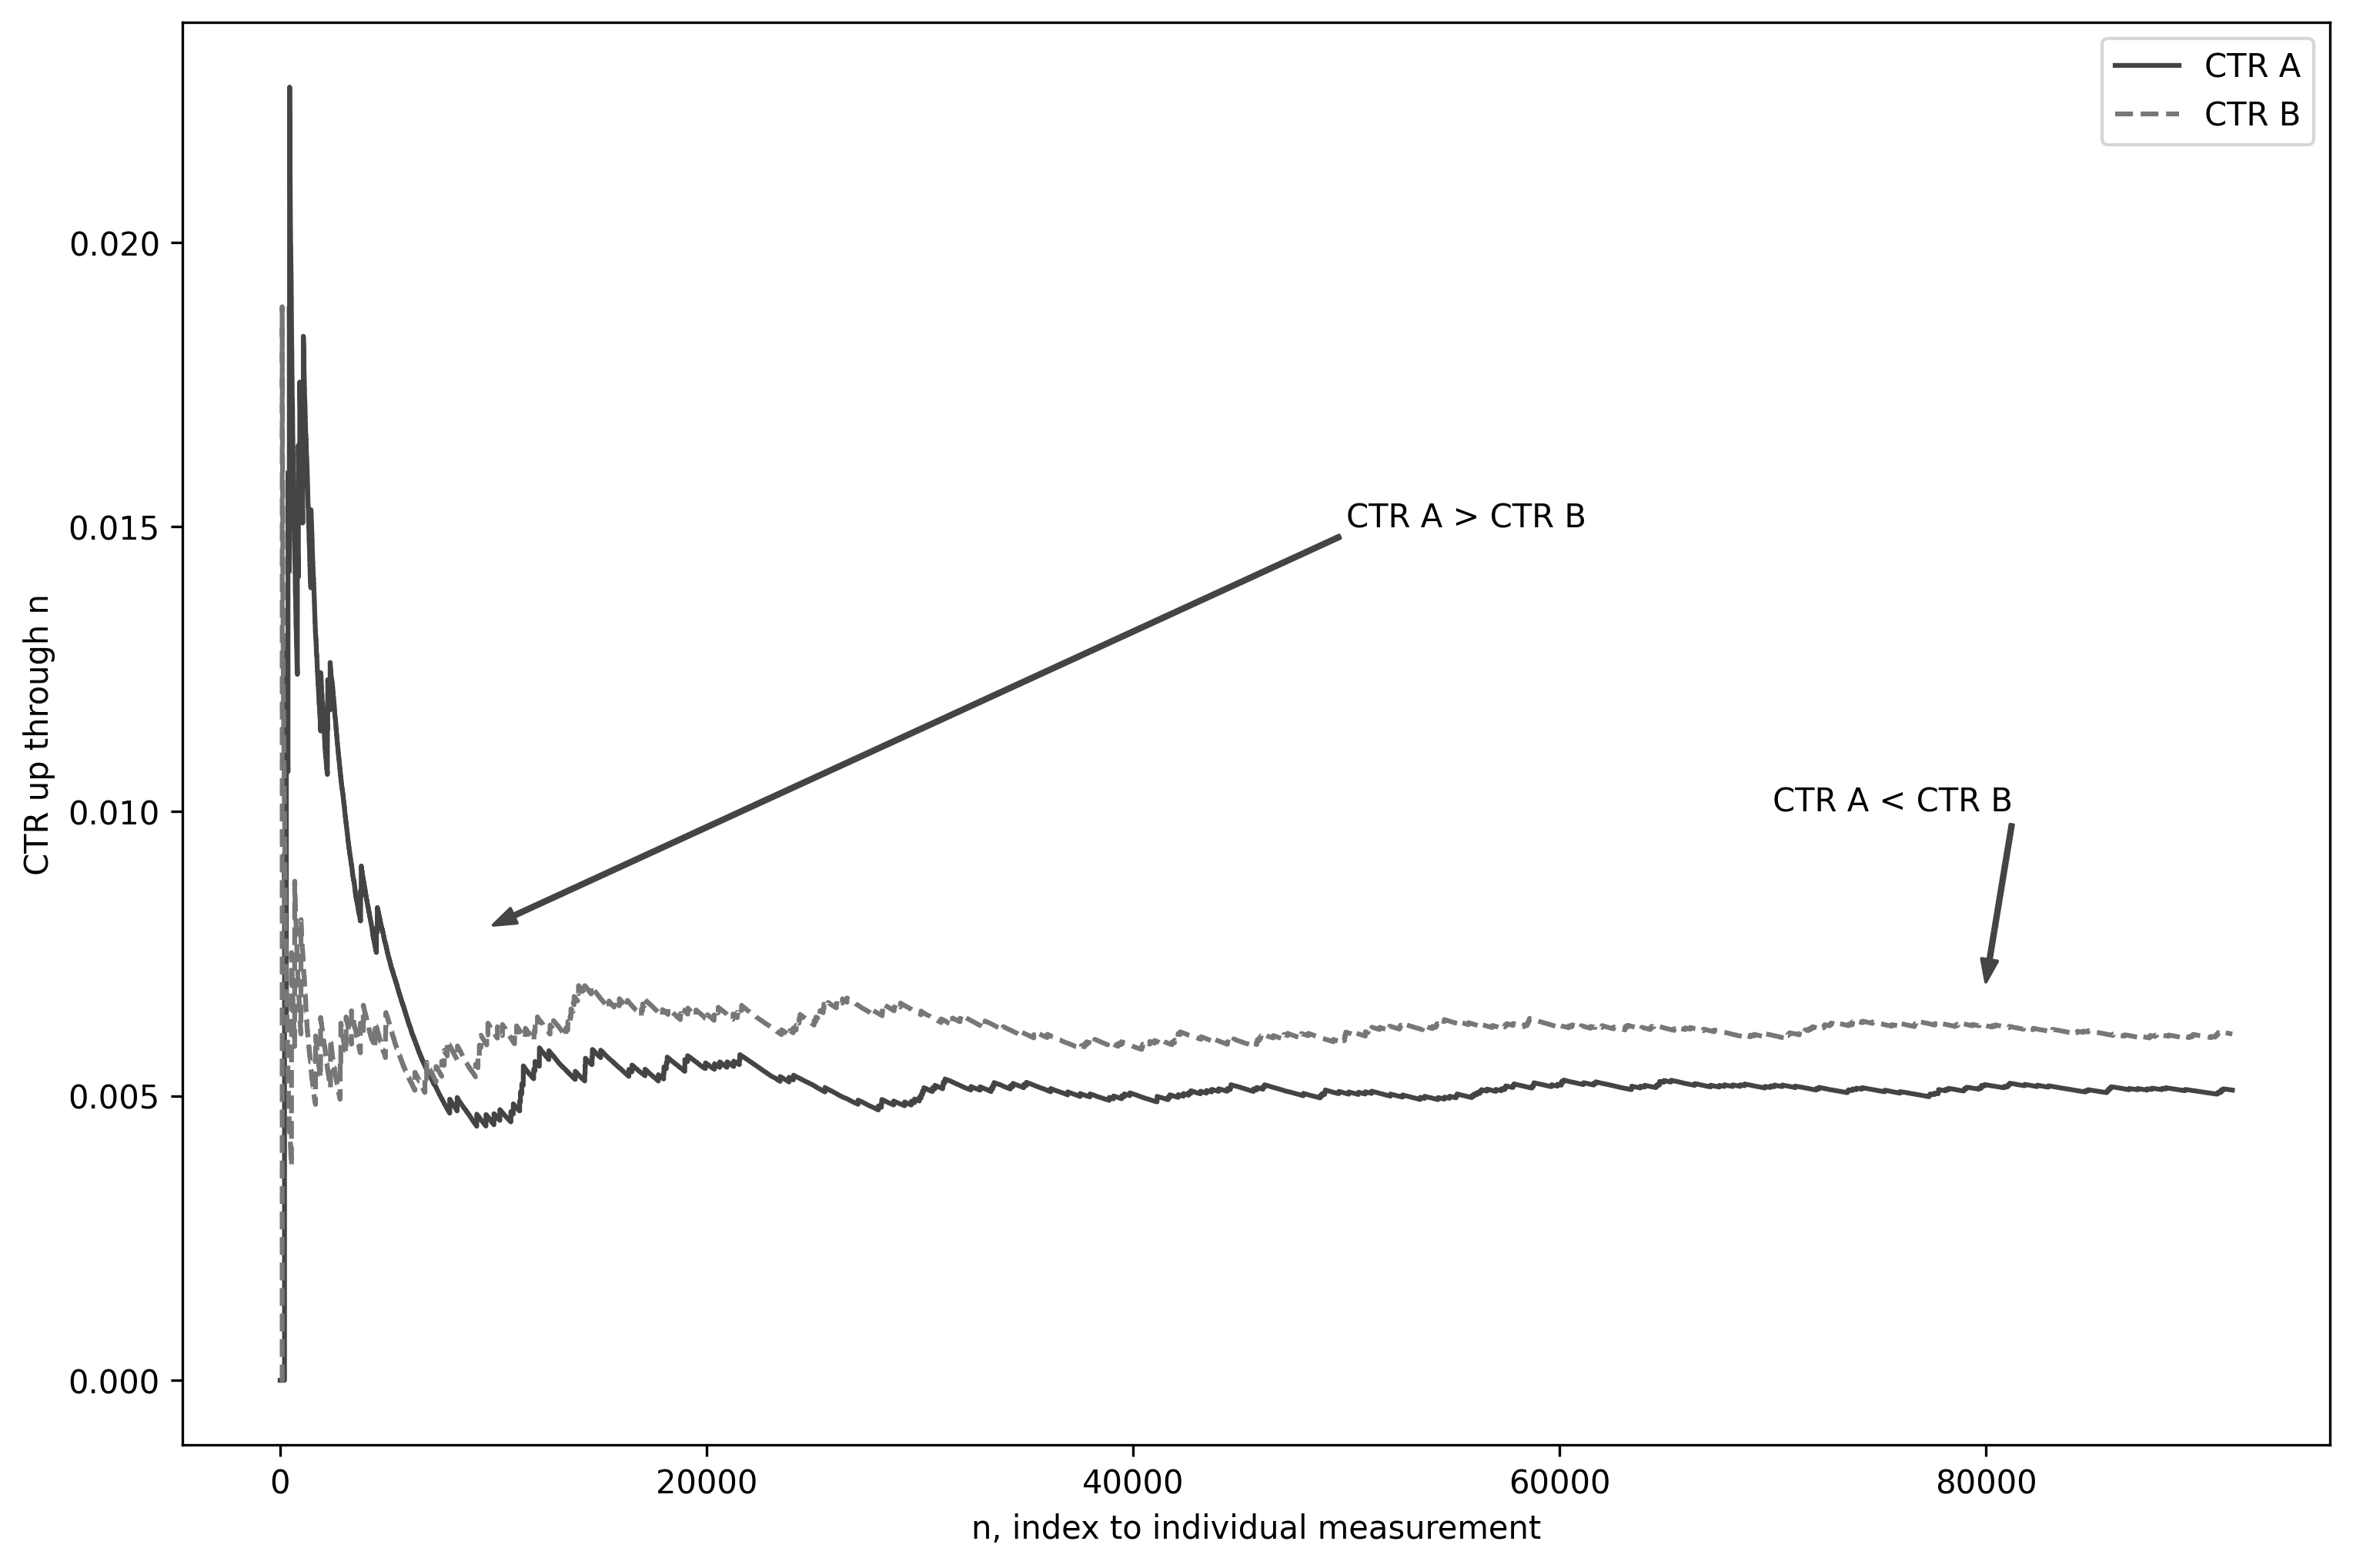

In [669]:
# compare the variations in ctr of model a vs ctr of model b
plt.figure(figsize=(12,8))
plt.plot(ctr_a, '-', color=e4e.color_1)             # click through rate for a versus individual measurement
plt.plot(ctr_b, '--', color=e4e.color_2)            # click through rate for b versus individual measurement
print(ctr_a[-1], ctr_b[-1])                         # final click through rates for a and b
plt.xlabel("n, index to individual measurement")
plt.ylabel("CTR up through n")
plt.legend(["CTR A", "CTR B"])
plt.annotate("CTR A > CTR B", xy=[10000, .0080],
             xytext=[50000, .015],
             arrowprops=e4e.arrow_props)  # xy and xytext location added by looking at plot
plt.annotate("CTR A < CTR B", xy=[80000, 0.0070],
             xytext=[70000, .010],
             arrowprops=e4e.arrow_props)
plt.show()

In [670]:
# Running ab test multiple times
def run_multi(trace_fn, num=100):
    traces = []
    for _ in range(num):
        trace = trace_fn()          # trace_fn calls ab_test() and returns ctr_vs_n, see below
        traces.append(trace)        # list of lists, each inner list is ctr_vs_n of one run of run_multi

    traces = np.array(traces)       # convert the list of lists into an ndarray, for mean, std calculation

    means = traces.mean(axis=0)     # calculate mean and std for each number of ads served, axis=0
    stds = traces.std(axis=0)

    return means, stds              # expected ctr and its standard deviation 

In [671]:
np.random.seed(7)
means_ab, stds_ab = run_multi(lambda: ab_test(num_ind)[0], 100) # trace_fn returns overall click through rate
print(means_ab[-1], stds_ab[-1])    # mean and standard deviation when all adds are served

0.005977763458240955 0.00026353657784965856


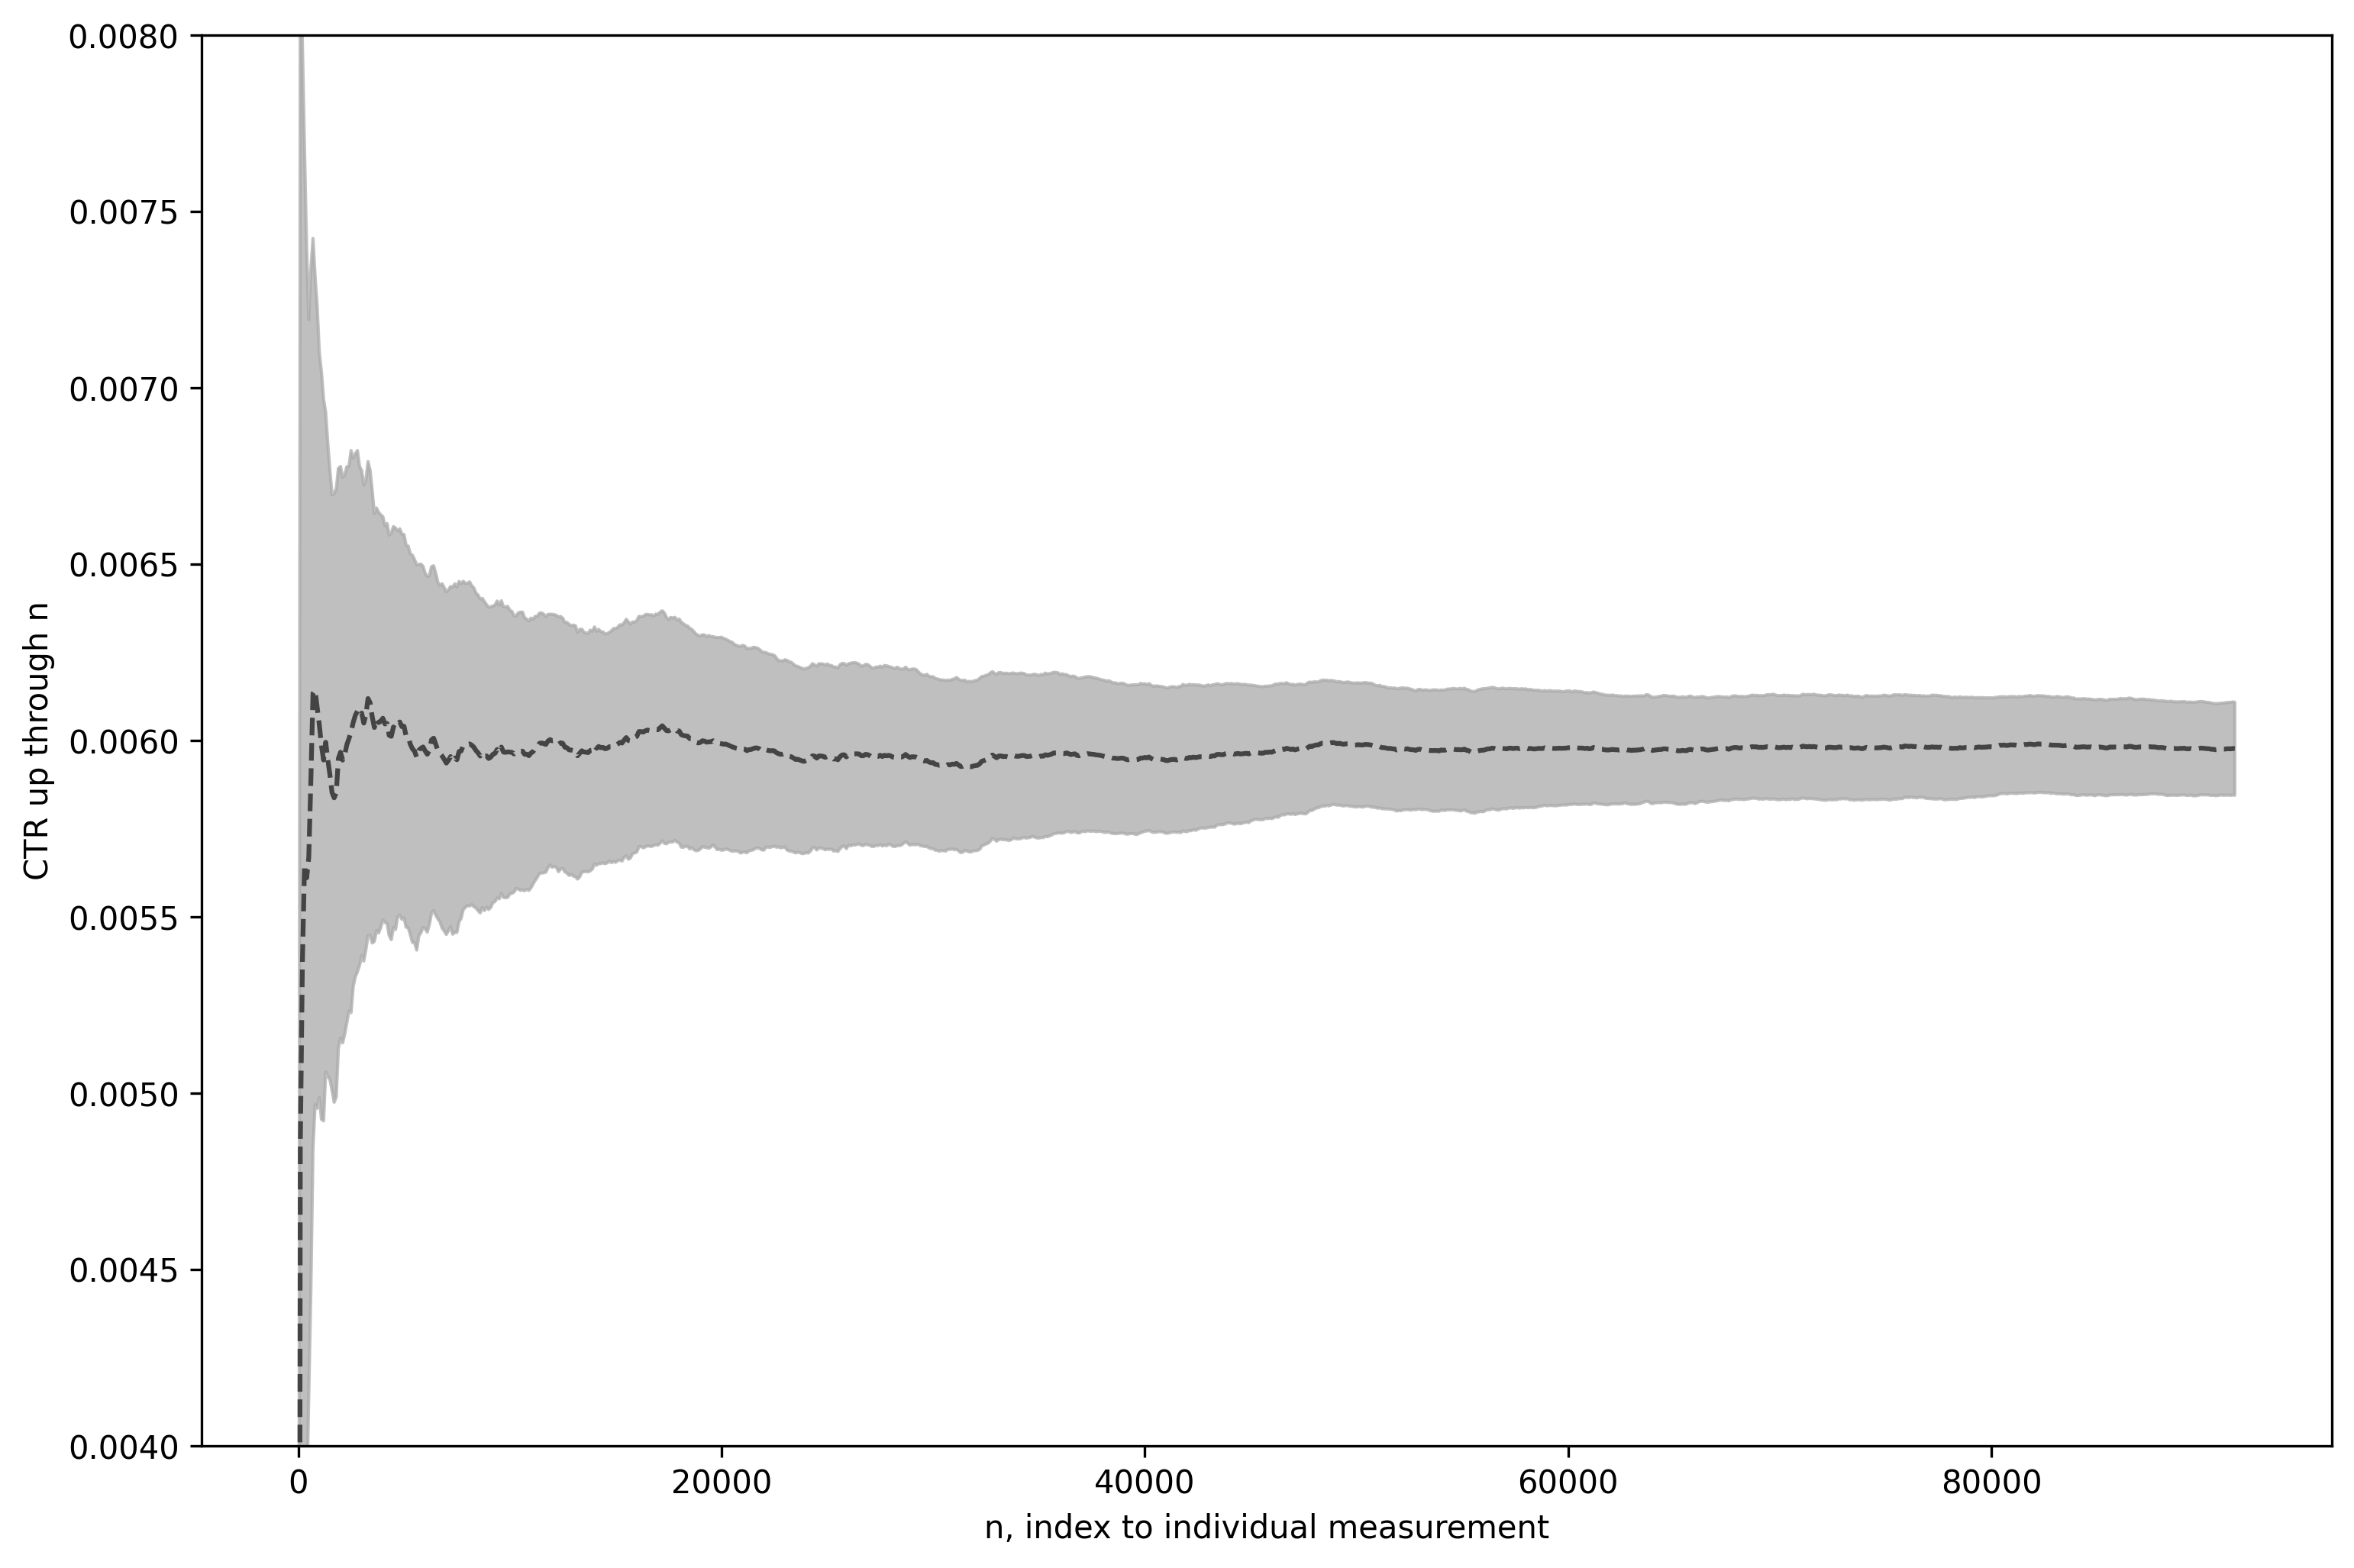

In [672]:
n = np.arange(len(means_ab))[::100]  # steps of 100 (start:end:step) show dashes dont become single line
plt.figure(figsize=(12,8))
plt.fill_between(n,
                 (means_ab - stds_ab/2)[::100],             # steps of 100
                 (means_ab + stds_ab/2)[::100],             # steps of 100
                 color=e4e.color_3, alpha=.75, linewidth=1
                 )                  # plot the std variation around the mean ctr per ads served
plt.plot(n, means_ab[::100], '--', color=e4e.color_1)  # ads served vs mean ctr
c = plt.axis()          # axis values chosen by matplotlib, xmin, xmax, ymin, ymax
plt.xlabel('n, index to individual measurement')        
plt.ylabel('CTR up through n')
plt.axis([c[0], c[1], .0040, 0.0080])       # xmin, xmax, custom ymin, custom ymax for zoom effect
plt.show()

#### The epsilon-greedy algorithm

What if we can analyze our data on the go to choose the better option, and take more data points from the better option. If the two options are about the same, half the time, we would think one option is better, the other half of the time, we would think the other option is better, therefore taking roughly the same data points like a traditional A/B test. If one option is clearly better, we reap the benefits during experimentation. Choosing the better option is called exploitation. Taking data on both options is called exploration. It's still valuable to have some data on both options, hence we need some exploration. The balance between exploitation and exploration is given by the parameter, epsilon. If epsilon is 0.10, then we in exploitation 90% of the time, and exploration 10% of the time (1 - epsilon). 

This is a greedy algorithm, because in the exploitation step, we choose the most beneficial option at the expense of data points for the other option. This exploration / exploitation  alogirthm is fully known as an epsilon-greedy algorithm. When the experimentation data as a whole is analyzed, the value of the business metric during experimentation will be closer to the optimal option.

In [673]:
def epsilon_greedy(num_ind, epsilon):
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0
    ctr_vs_n = []
    used_b = []
    for _ in range(num_ind):
        select = "Randomize"            # for each add, initialize select boolean to randomize
        if np.random.uniform(0,1) < 1 - epsilon:        # with p(1-epsilon) optimize option choice (exploit)
            ctr_a = sum_a / num_a if num_a > 0 else 0   # ctr calculation, initialize to 0 if no adds served
            ctr_b = sum_b / num_b if num_b > 0 else 0
            if ctr_a > ctr_b :          # if A performs better, update select boolean to A
                select = "A"
            elif ctr_b > ctr_a :        # if B performs better, update select boolean to B
                select = "B"
            # else, if they're equal (0 or otherwise), randomize
        else:
            if select == "Randomize" :      # with p(epsilon), choose option randomly (explore)
                if np.random.uniform(0,1) < 0.5 :   # half the randomized time, update select boolean to A/B
                    select = "A"                    # update select boolean to A
                else:                                        
                    select = "B"                    # update select boolean to B 
        
        if select == "A":                       
            clicked = measure_a()               # run model A, return boolean for whether user clicked
            sum_a += clicked                    # track number of model A ads that user clicked
            num_a += 1                          # total number of adds recommended by model A
            used_b.append(False)                # track if superior model (known to be B here) is used
        else:
            clicked = measure_b()               # run model B, return boolean for whether user clicked
            sum_b += clicked                    # track number of model B ads that user clicked
            num_b += 1                          # total number of adds recommended by model B
            used_b.append(True)                 # track if superior model (known to be B here) is used

        sum_clicks += clicked               # total ads clicked by users, for overall ctr calculation
        num_ads += 1                        # total ads shown to users, for overall ctr calculation
        ctr_vs_n.append(sum_clicks / num_ads)       # overall ctr so far
    
    return ctr_vs_n, used_b

In [674]:
np.random.seed(17)
ctr_eps_greedy = epsilon_greedy(num_ind=num_ind, epsilon=0.1)[0]
print(ctr_eps_greedy[-1])

0.007153700811480871


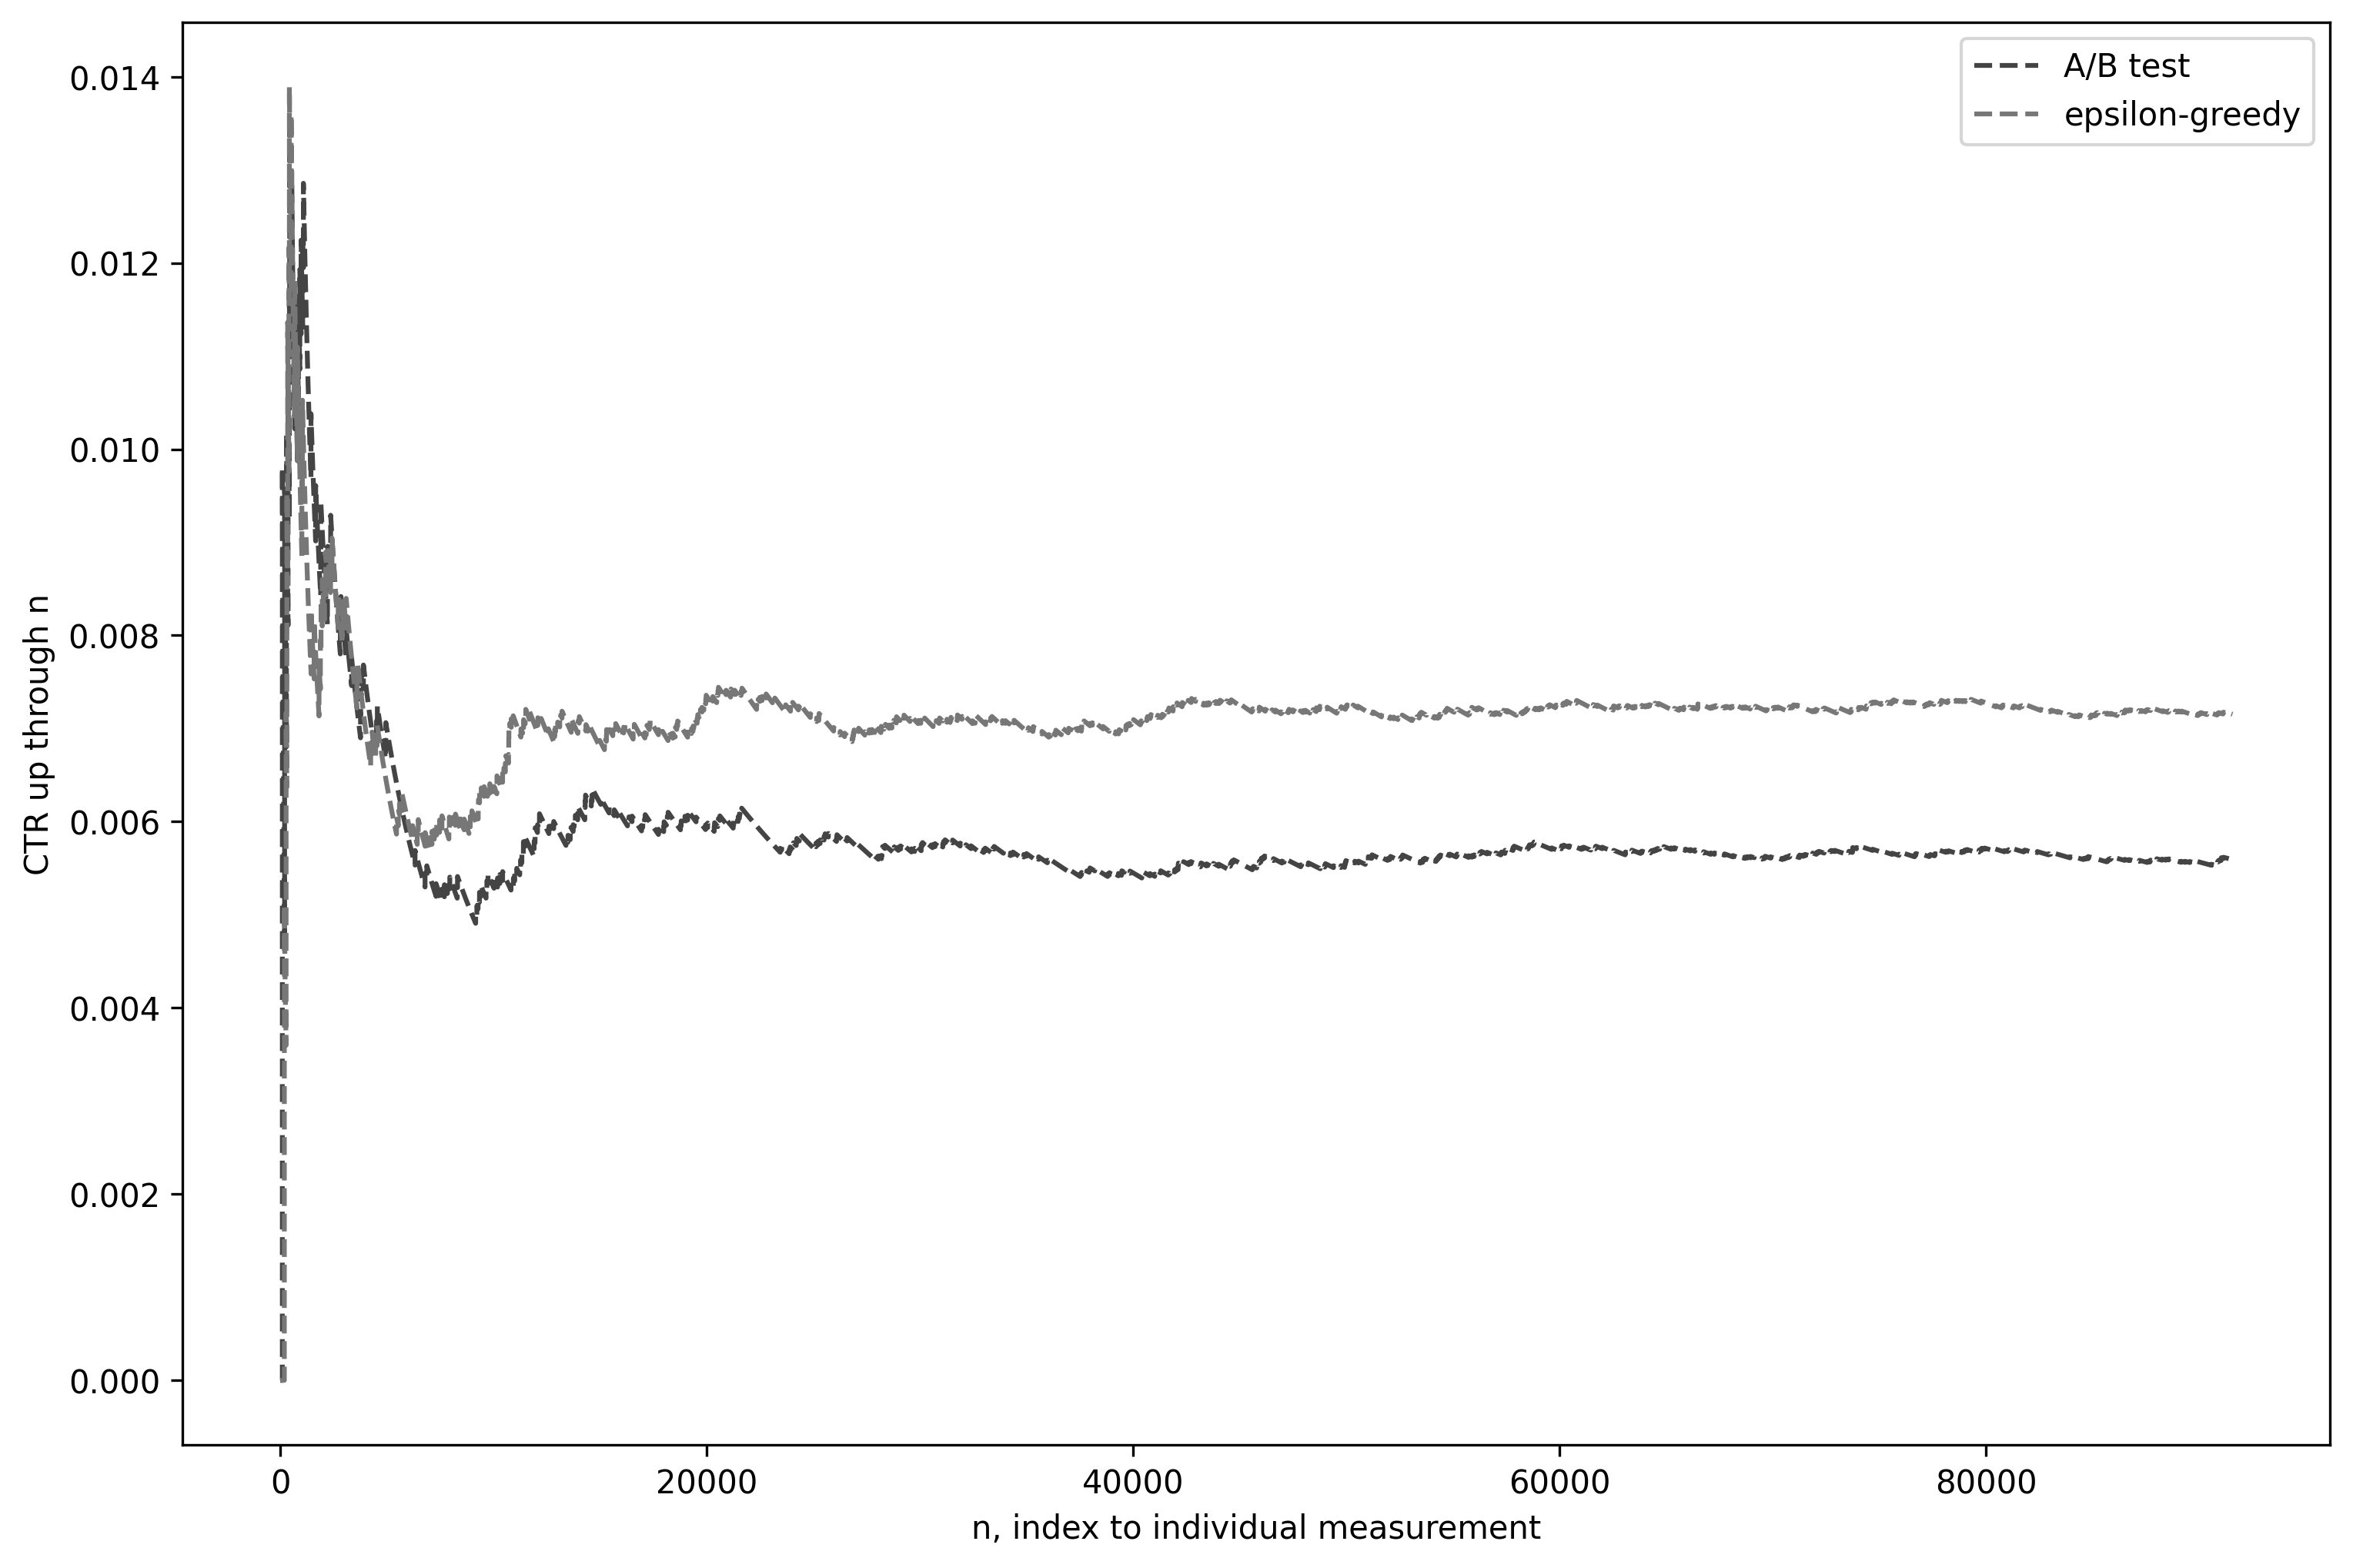

In [675]:
plt.figure(figsize=(12,8))
plt.plot(ctr_vs_n, '--', color=e4e.color_1)
plt.plot(ctr_eps_greedy, '--', color=e4e.color_2)
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n')
plt.legend(['A/B test', 'epsilon-greedy'])
plt.show()

In [676]:
ctr_eps_greedy[-1] - ctr_vs_n[-1]

0.0015618003298347553

In [677]:
# Run epsilon-greedy many times
np.random.seed(17)
means_eg, stds_eg = run_multi(lambda: epsilon_greedy(num_ind, epsilon=0.1)[0], 100)
print(means_eg[-1], stds_eg[-1]) # consistently getting higher ctrs than average of two models a,b

0.006779851683577068 0.0004443818455028741


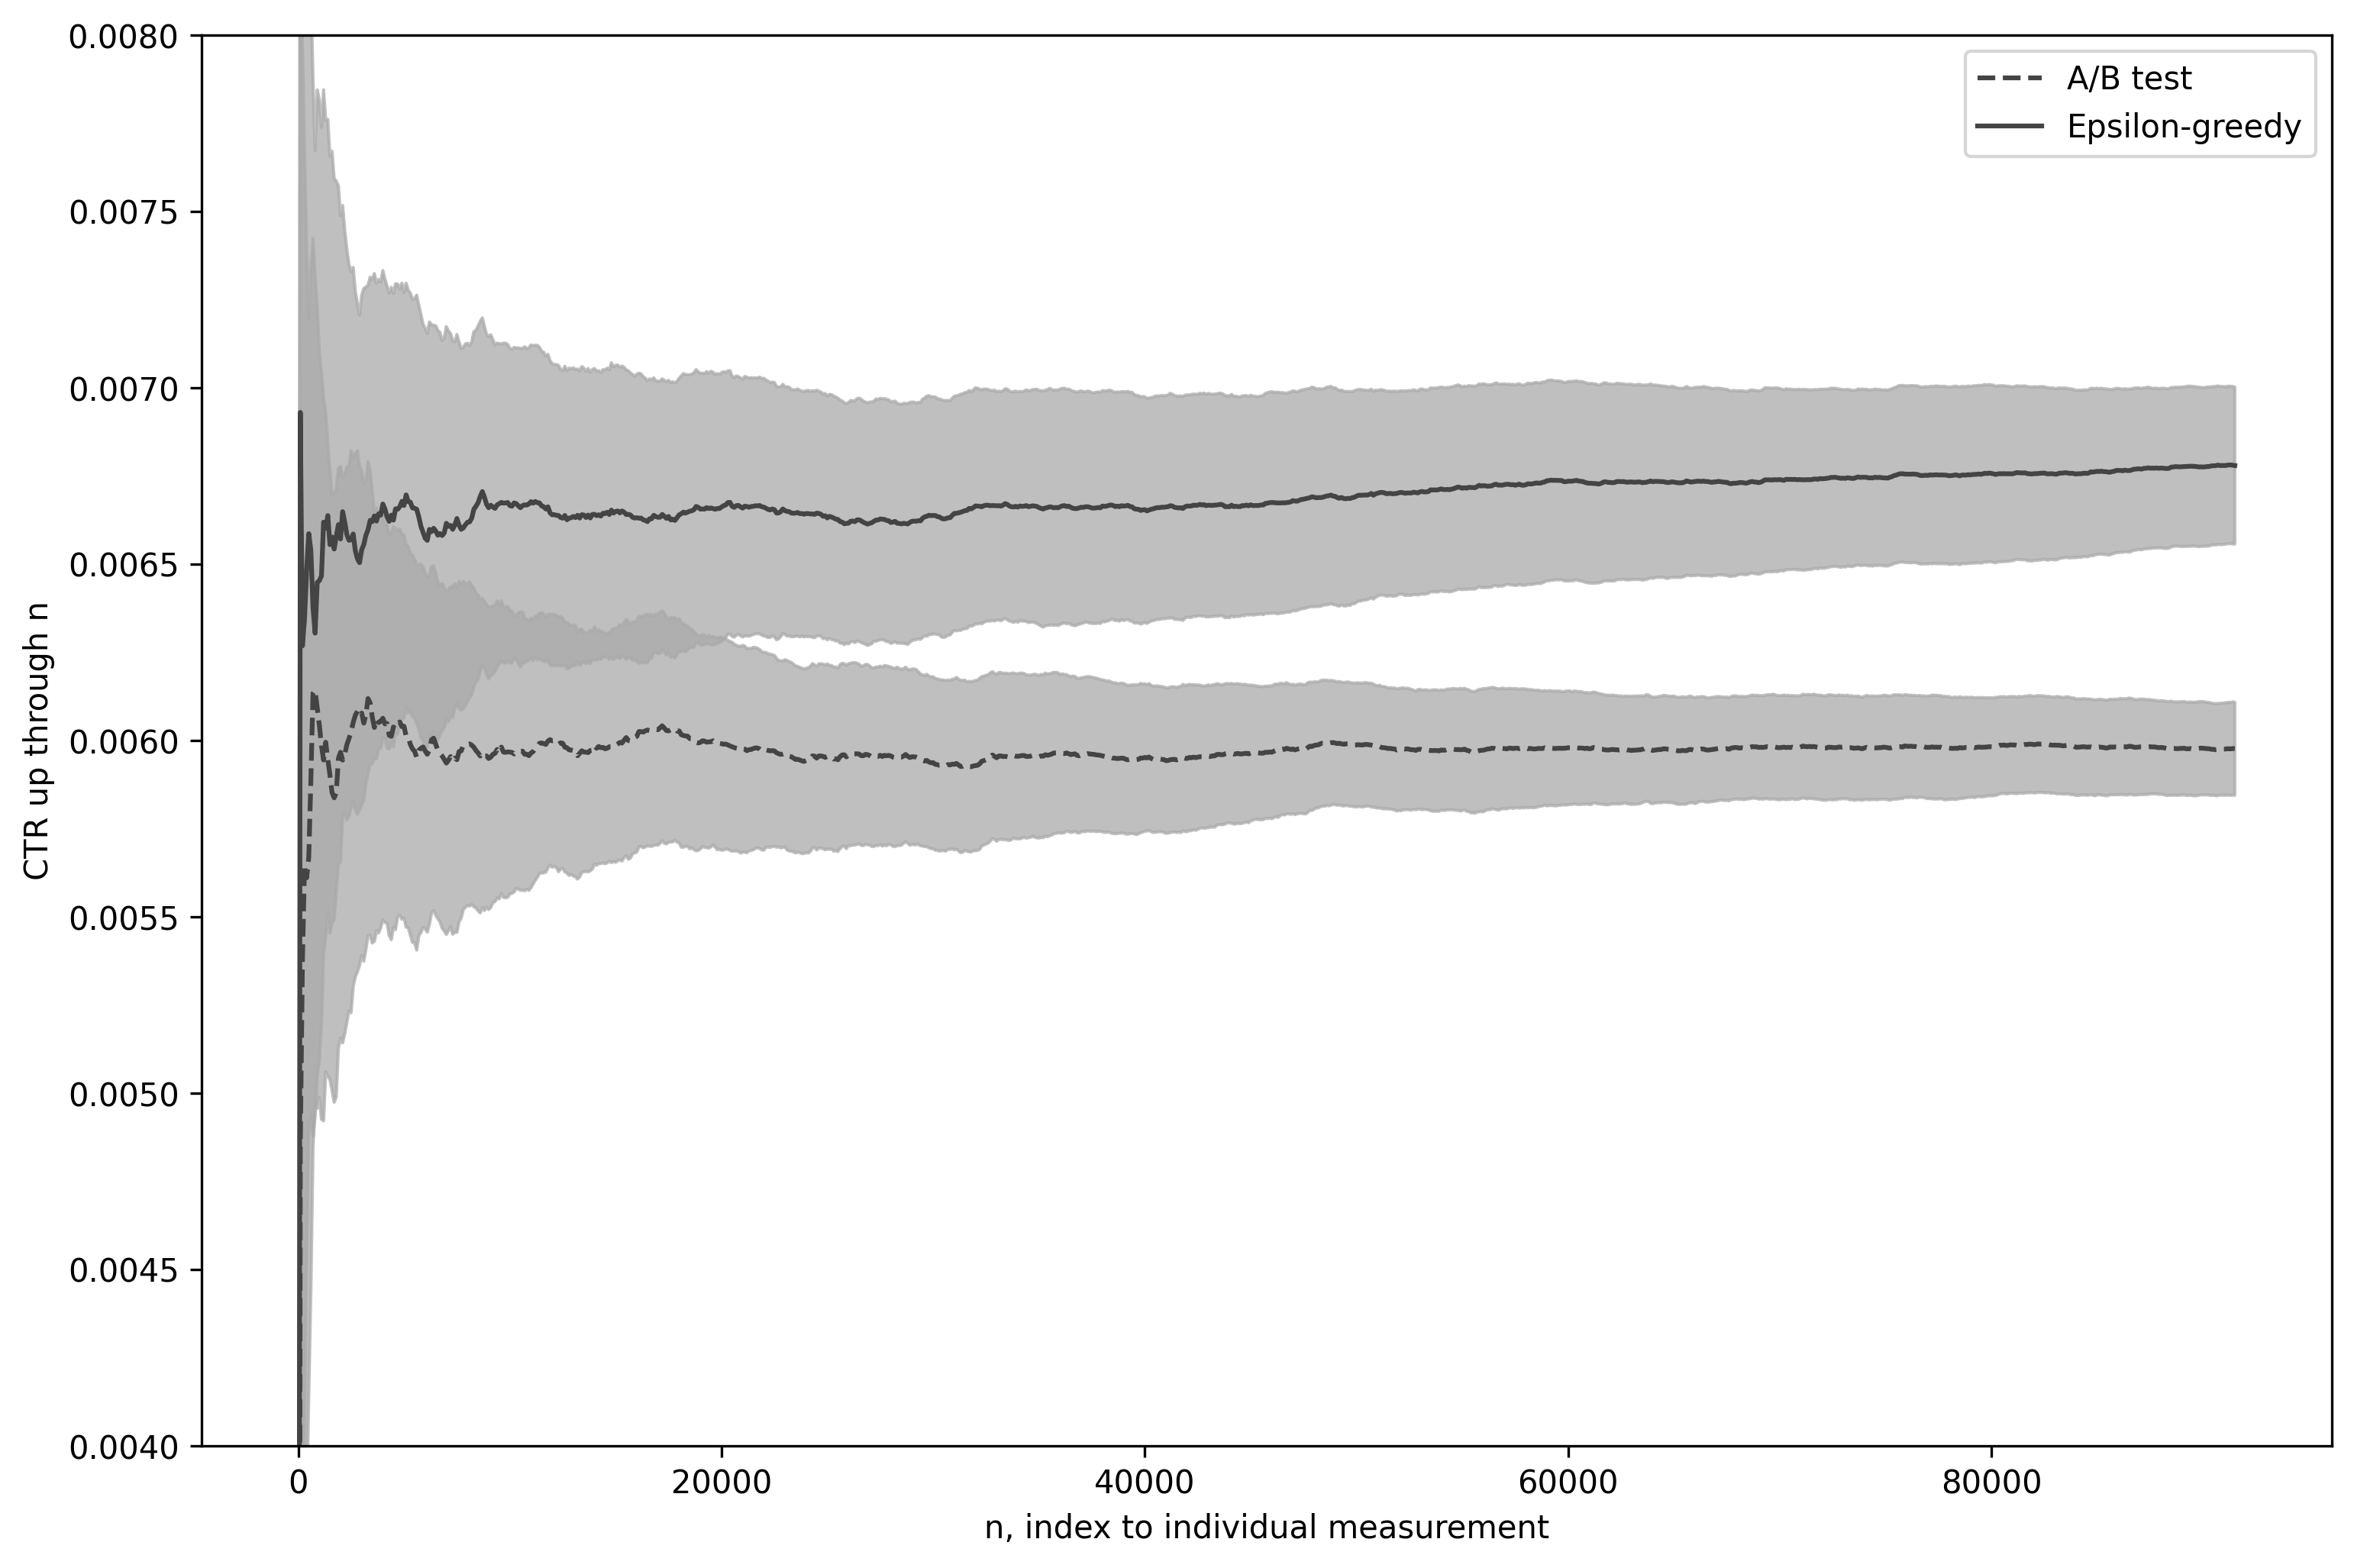

In [678]:
means_eg_tr = means_eg[-len(means_ab):]   # as many data points in epsilon greedy means as ab test means
stds_eg_tr = stds_eg[-len(stds_ab):]

n = np.arange(len(means_ab))[::100]    # slice out in steps of 100 for n, index of trials

plt.figure(figsize=(12,8))

plt.fill_between(n,
                 (means_ab - stds_ab/2)[::100],
                 (means_ab + stds_ab/2)[::100],
                 color=e4e.color_3, alpha=.75, linewidth=1
                 )      # plot the std variation around the mean ctr per ads served
plt.plot(n, means_ab[::100], '--', color=e4e.color_1, label='A/B test')  # ads served vs mean ctr

plt.fill_between(n,
                 (means_eg_tr - stds_eg_tr/2)[::100],
                 (means_eg_tr + stds_eg_tr/2)[::100],
                 color=e4e.color_3, alpha=.75, linewidth=1
                 )      # plot the std variation around the mean ctr per ads served
plt.plot(n, means_eg_tr[::100], '-', color=e4e.color_1, label='Epsilon-greedy')  # ads served vs mean ctr

c = plt.axis()          # axis values chosen by matplotlib, xmin, xmax, ymin, ymax
plt.xlabel('n, index to individual measurement')        
plt.ylabel('CTR up through n')
plt.axis([c[0], c[1], .0040, 0.0080])       # xmin, xmax, custom ymin, custom ymax for zoom effect
plt.legend()
plt.show()

In [679]:
def run_multi_selection_rate(selected_fn, num=100):
    selected = []
    for _ in range(num):                # selected_fn is epsilon greedy returns used_B for each number of ads
        selected.append(selected_fn())  # used_B (booleans) to calculate rate of using optimal model or not
    
    selected = np.array(selected)       # convert list of lists to 2D ndarray of True/False num times
    indices = np.unique(selected)       # unique values : True , False
    rate_selected = []
    for i in indices:                   # For each of True / False for whether model b was used
        chis = selected == i            # mark the entries that correspond using booleans
        rate_selected.append(chis.mean(axis=0)) # average of times model b/a used/not for each number of ads
    rate_selected = np.array(rate_selected)     # store averages for when model b was used/not per ads number

    return indices, rate_selected       # indices to match the rate selected calculation

In [680]:
np.random.seed(17)
indices, rate_selected = run_multi_selection_rate(lambda: epsilon_greedy(num_ind,epsilon=0.1)[-1], 100)
print(indices)   # the indices give us an indication of which rate_selected refers to model B being used or not

[False  True]


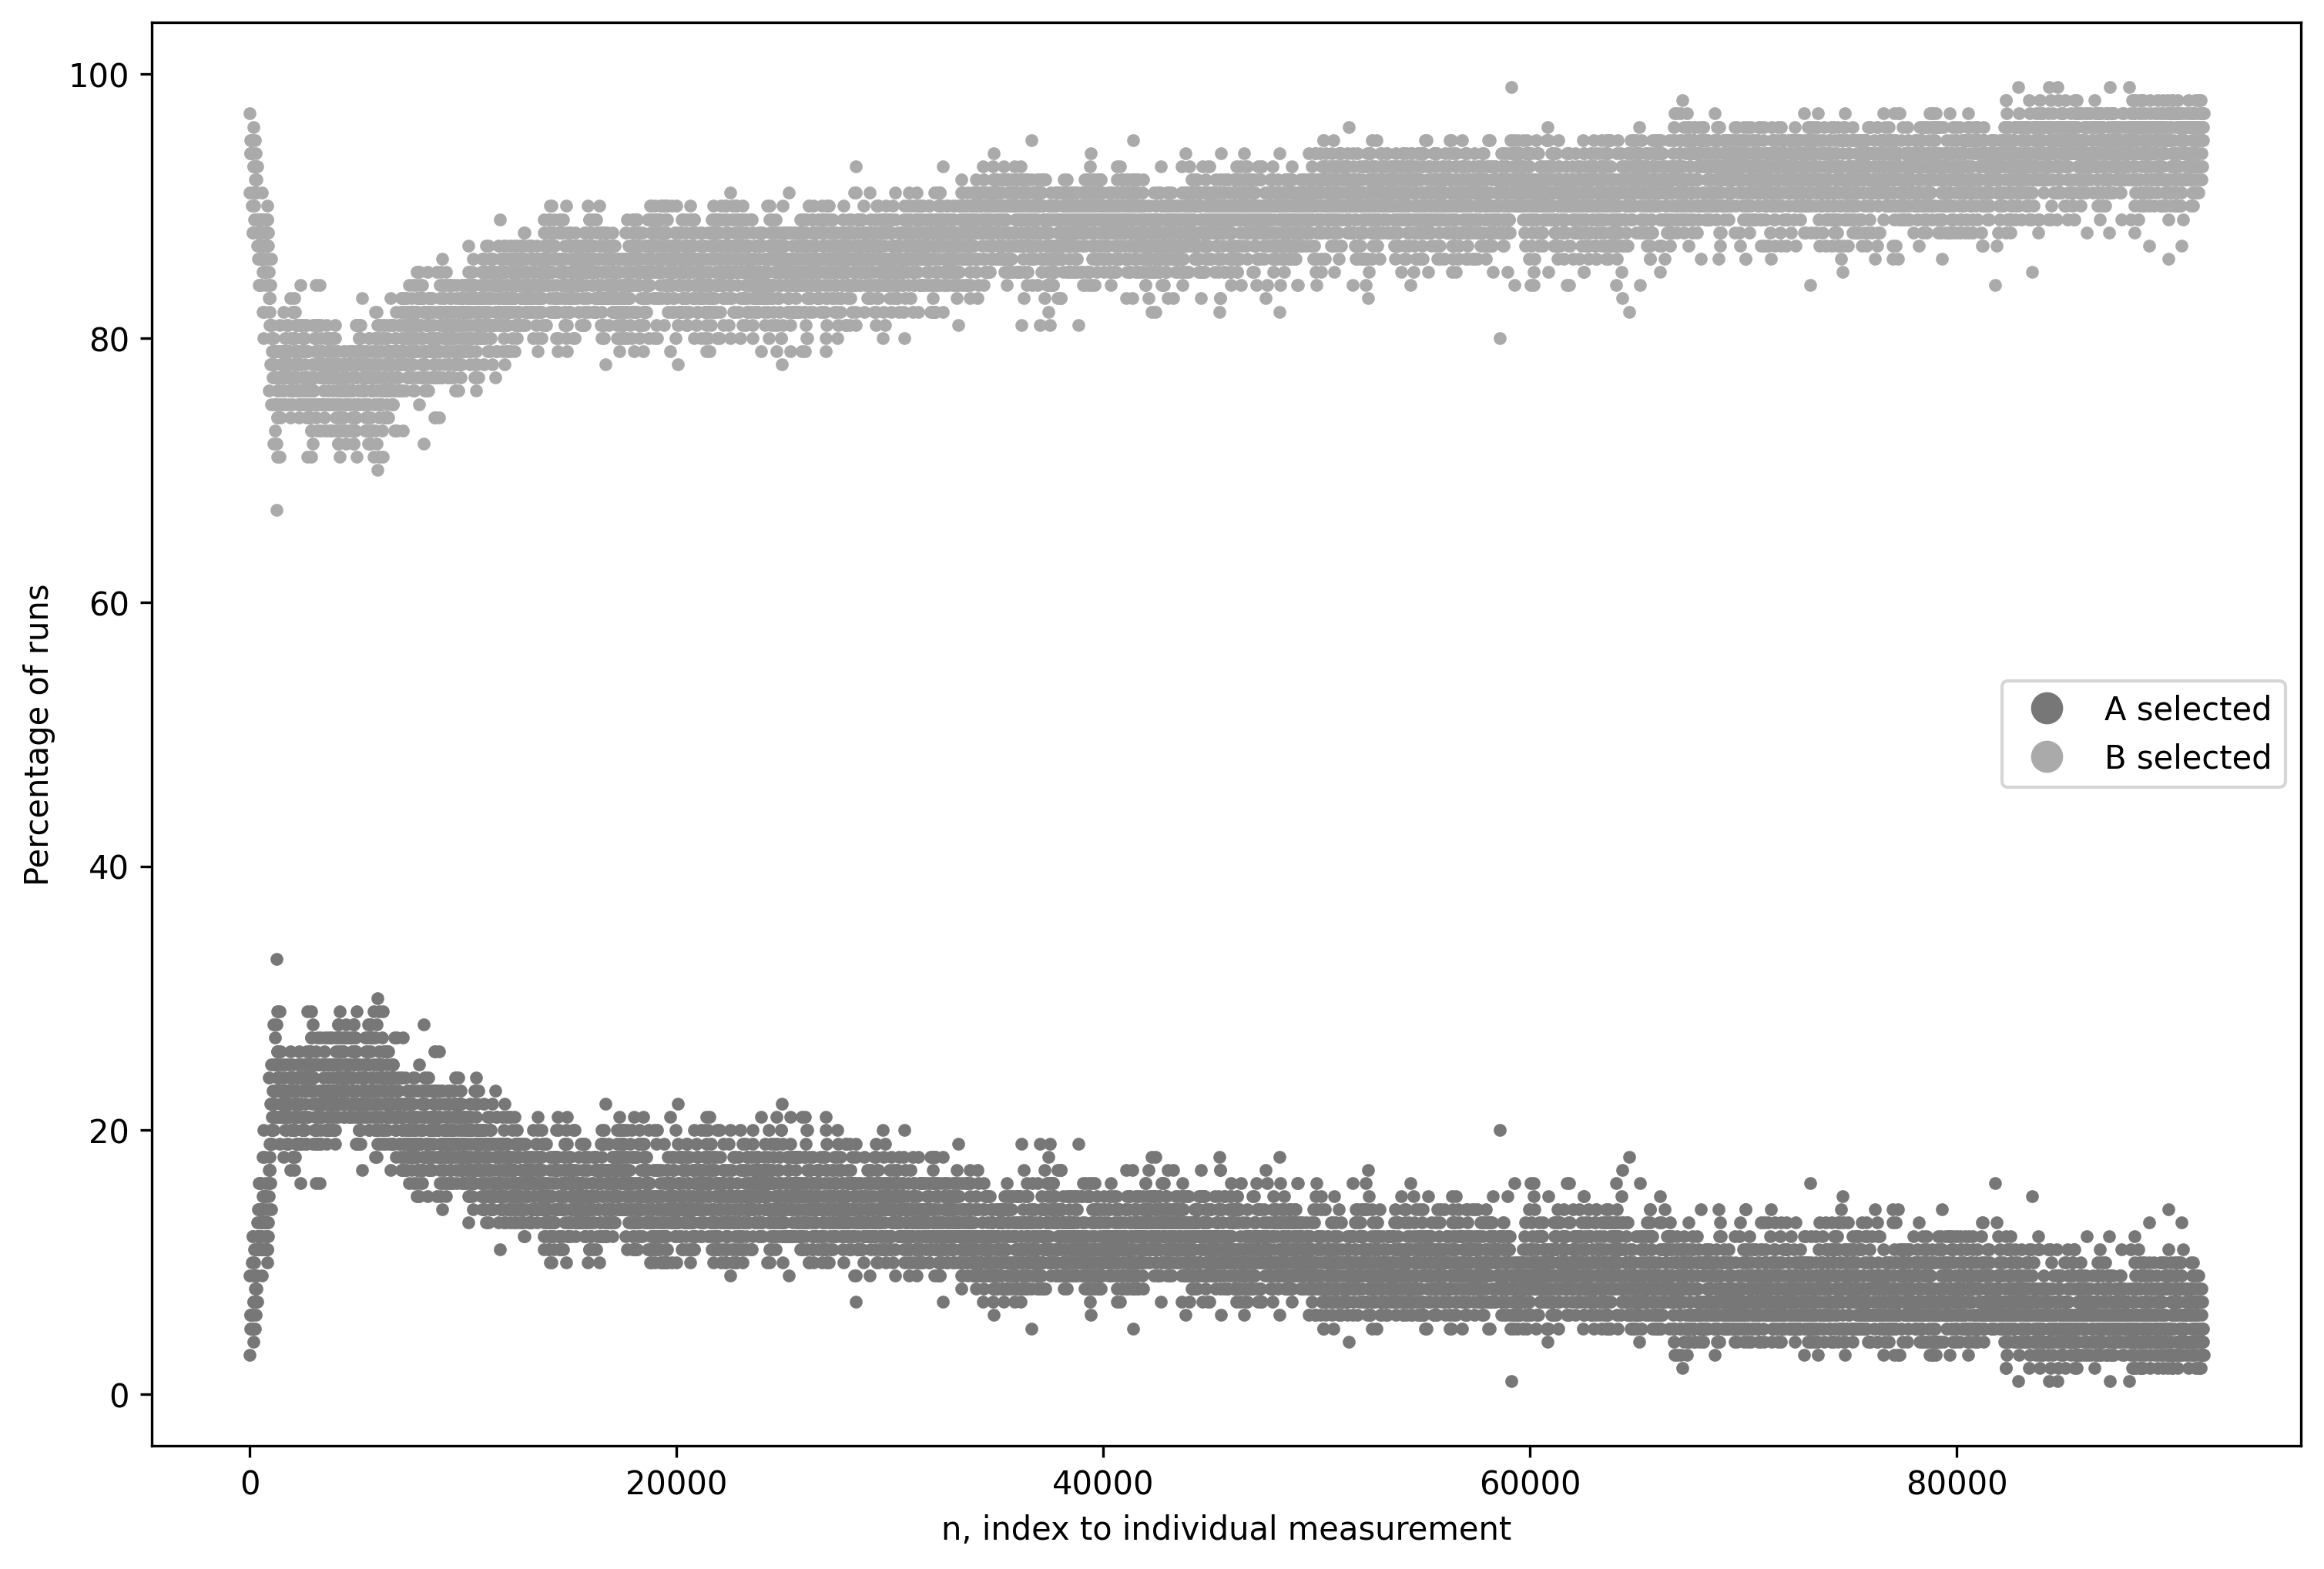

In [681]:
n = np.arange(rate_selected.shape[1])
plt.figure(figsize=(12,8))
plt.plot(n[::10], 100*rate_selected[0,:][::10], '.', color=e4e.color_2) # rate at which model A was selected
plt.plot(n[::10], 100*rate_selected[1,:][::10], '.', color=e4e.color_3) # rate at which model B was selected
plt.legend(['A selected', 'B selected'], markerscale=3)
plt.ylabel('Percentage of runs')
plt.xlabel('n, index to individual measurement')
plt.show()

#### Deciding when to stop using decaying epsilon

The epsilon-greedy algorithm, unlike an A/B test, is not run for a set number of times. A/B test chooses the number of trials because the aim is to limit the false positive rate and false negative rate. Epsilon-greedy on the other hand is used to maximize the business metric during the period of the experiment. Remember that the epsilon parameter is the proportion of time spent in exploration. Since the aim of epsilon-greedy is to maximize business metric, at some point we want the system to stop exploring and only exploit. This is achieved by using a decaying epsilon value, which is proportional to $1/n$, where $n$ is the iteration. This means that epsilon slowly decays to zero.

epsilon = $2*c*\frac{(\frac{BM_{max}}{PS})^2}{n}$

where  ${BM_{max}}$  = largest plausible value of business metric (as scale for PS)

n = current iteration

c = system-dependent metaparameter, controls the amount of time epsilon spends above 1, in pure exploration

PS = practical significance, minimum delta to warrant choosing B

Epsilon is initialized at a large value, and during this time, the system is in complete exploration. The epsilon value is updated upon each iteration as its proportional to $1/n$. When epsilon gets to a value below 1, then exploitation begins to take place, in addition to exploration. The metaparameter $c$ controls the amount of time, epsilon is above 1, and thus in pure exploration. Instead of waiting for epsilon to slowly decay to 0, we can set a epsilon threshold, so that when epsilon reaches that value, we end the algorithm. By the end of the algorithm, each exploitation phase will identify the same option as being optimal. Epsilon-greedy with decaying epsilon has been shown to exhibit optimal regret.

In [682]:
# Epsilon-greedy with decaying epsilon
def epsilon_greedy_decay():
    bm_max = 0.01           # the maximum possible value for click through rate is 1%
    prac_sig = 0.001        # we want to see a 0.1% change in click through rate
    c = 5

    epsilon_0 = 2 * c * (bm_max / prac_sig)**2      # initialize epsilon (non-dependent on iteration)
    epsilon_stop = 0.01

    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0
    ctr_vs_n  = []
    epsilons = []

    n = 0               # iteration
    selected = None     # boolean to track if B is chosen, only updated in exploitation
    while True:
        epsilon = min(1.0, epsilon_0 / (1.0 + n) )  # add 1 to n (div by 0). epsilon is 1 or less
        epsilons.append(epsilon)        # store epsilon values    
        if epsilon < epsilon_stop:      # use break statement here because of epsilon min() update above
            break                       # stop when epsilon is very small

        select = "Randomize"            # boolean for exploration / exploitation; initialize at exploration

        if np.random.uniform(0,1) < 1 - epsilon :   # exploit with probability p(1-epsilon)
            ctr_a = sum_a / num_a if num_a > 0 else 0   # initialize or update business metric for version A
            ctr_b = sum_b / num_b if num_b > 0 else 0   # initialize or update business metric for version B
            if ctr_a > ctr_b :          # if currently, the better performing version is A
                select = "A"            # update boolean to exploit using version A
                selected = "A"          # boolean to help track the last model chosen by exploitation
            elif ctr_b > ctr_a :        # if currently, the better performing version is B
                select = "B"            # update boolean to exploit using version B
                selected = "B"          # boolean to help track the last model chosen by exploitation

        if select == "Randomize":       # explore with probability p(epsilon)
            if np.random.uniform(0,1) < 0.5 :   # when exploring, use either model A half the time
                select  = "A"           # update boolean to exploit using version A
            else :                              # when exploring, use either model B half the time
                select = "B"            # update boolean to exploit using version B
        
        if select == "A":               # if exploring or exploiting using version A
            clicked = measure_a()       # serve ad using version A, return 0/1 for if user clicked ad
            sum_a += clicked            # track total ads clicked by users when ad is served by version A
            num_a += 1                  # total number of ads served by version A
        else:
            clicked = measure_b()       # serve ad using version B, return 0/1 for if user clicked ad
            sum_b += clicked            # track total ads clicked by users when ad is served by version B
            num_b += 1                  # total number of ads served by version B
        
        sum_clicks += clicked           # total ads clicked by users
        num_ads += 1                    # total ads served to users

        ctr_vs_n.append(sum_clicks / num_ads)   # store the overall click through rate
        n += 1                                  # increase the number of iterations

    if selected == "B":             # if the last version used during exploitation is version B
        accept_reject = "Accept"    # then accept version B to replace version A
    else:                           # if the last version used during exploitation is version A
        accept_reject = "Reject"    # then reject version B to replace version A

    return ctr_vs_n, epsilons, accept_reject

In [683]:
np.random.seed(17)
ctr_eps_greedy_decay, epsilons, accept_reject = epsilon_greedy_decay()
print( len(ctr_eps_greedy_decay), ctr_eps_greedy_decay[-1], accept_reject, epsilons[-1])

100000 0.00714 Accept 0.00999990000099999


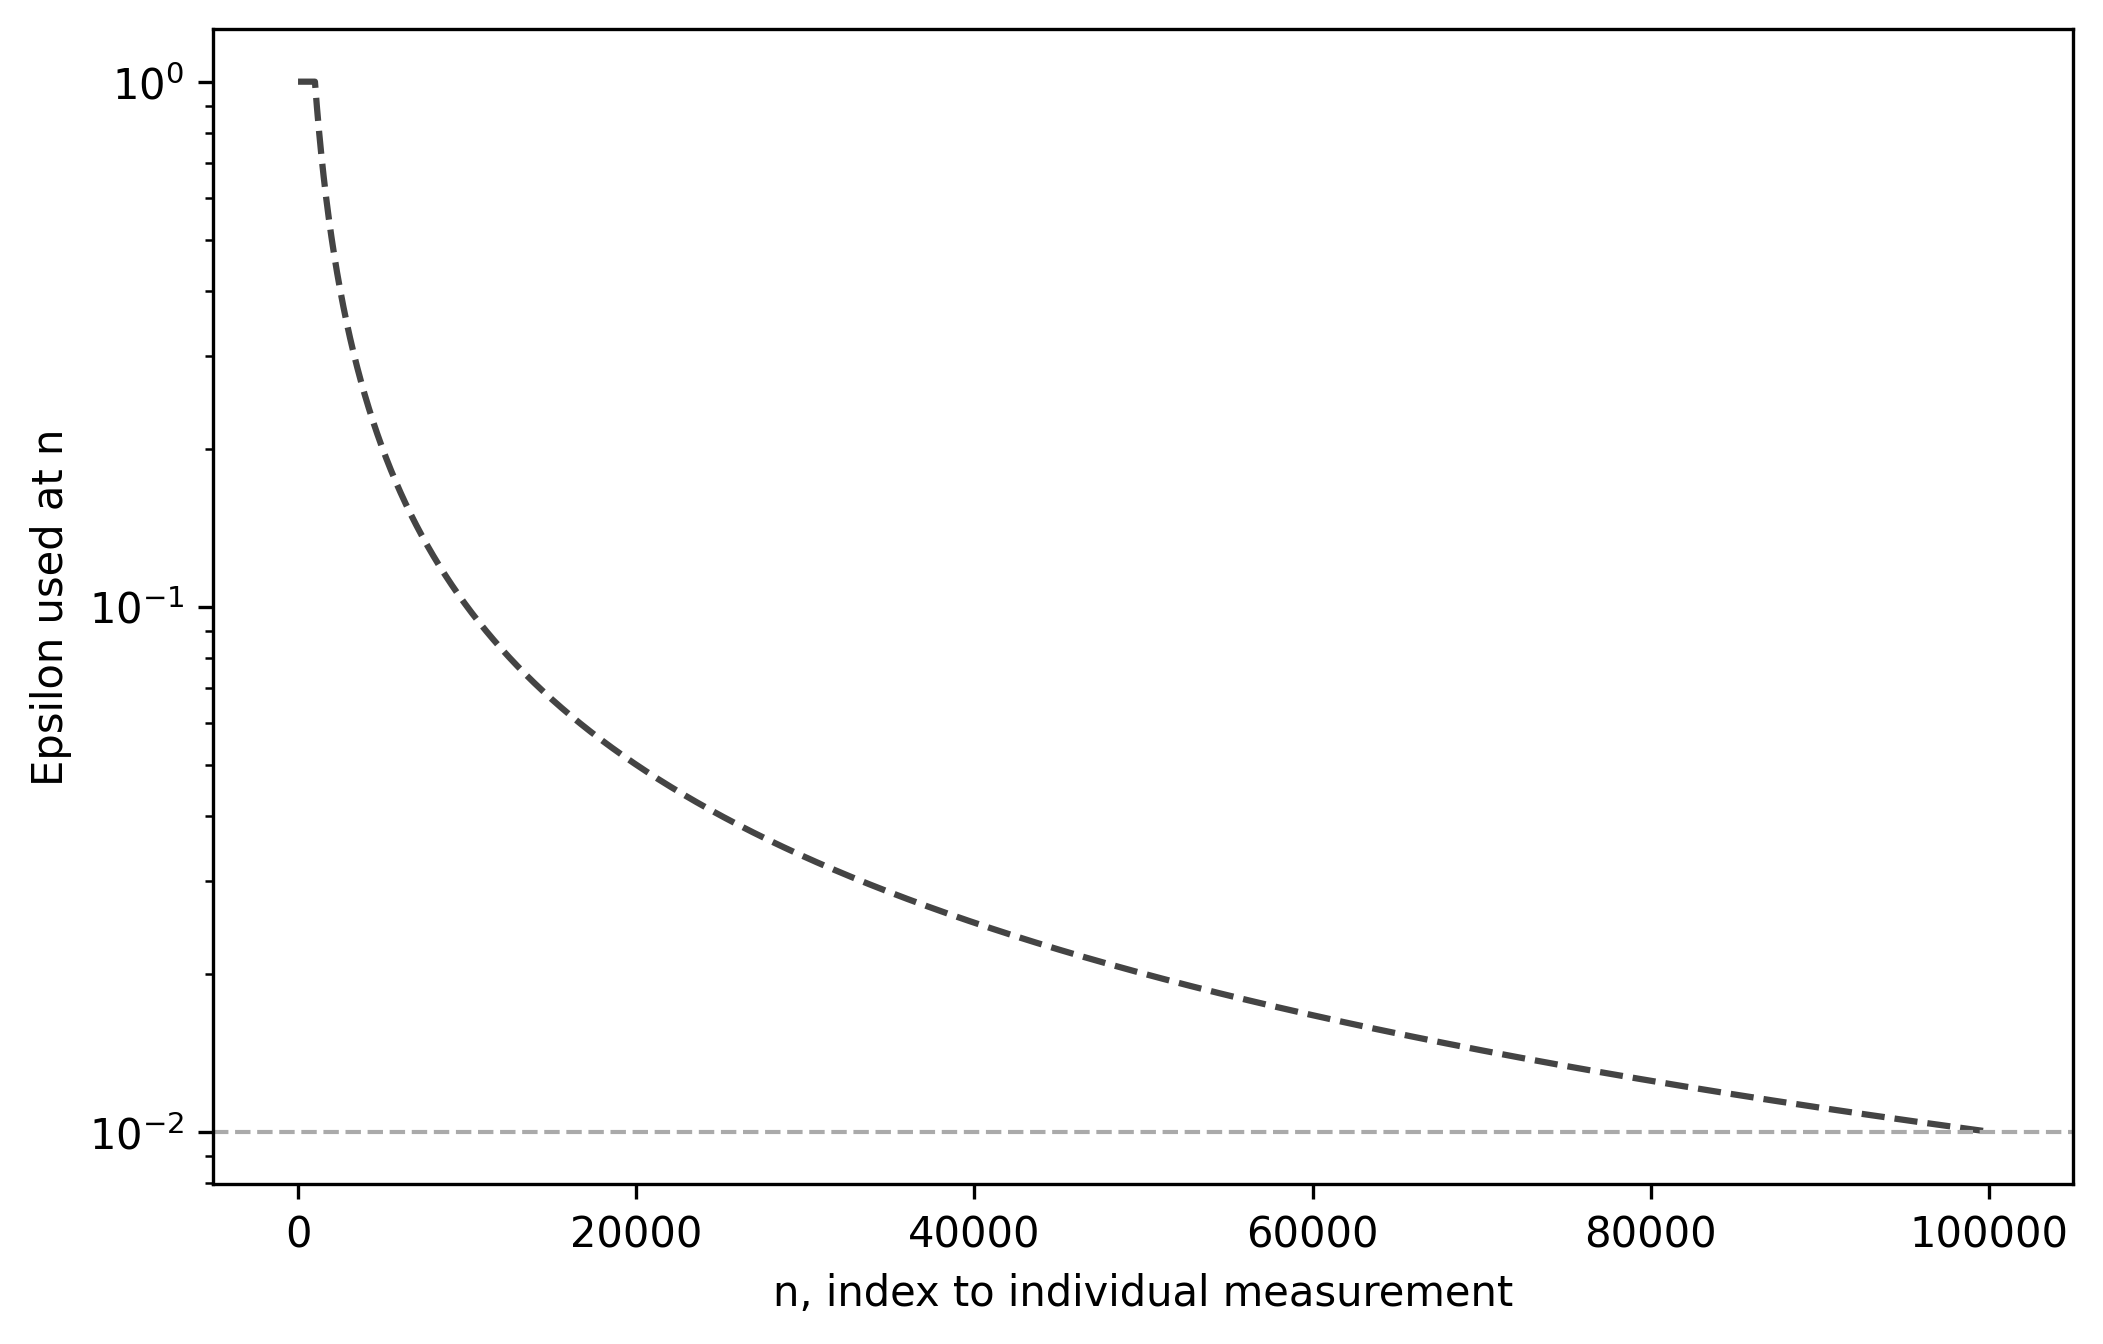

In [684]:
# Decaying epslion
plt.figure(figsize=(8,5))
plt.semilogy(epsilons, '--', color=e4e.color_1)  # y is in log scale
plt.xlabel('n, index to individual measurement')
plt.ylabel('Epsilon used at n')
e4e.horizontal_line(0.01)
plt.show()

In [685]:
# Epsilon-greedy with decaying epsilon
def epsilon_greedy_decay_compare(num_ind):
    bm_max = 0.01
    prac_sig = 0.001
    c = 5

    epsilon_0 = 2 * c * (bm_max / prac_sig)**2      # initialize epsilon (non-dependent on iteration)
    epsilon_stop = 0.01

    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0
    ctr_vs_n  = []
    epsilons = []

    n = 0               # iteration
    selected = None 
    for n in range(num_ind):
        epsilon = min(1.0, epsilon_0 / (1.0 + n) )  # add 1 to n (div by 0). epsilon is 1 or less
        epsilons.append(epsilon)        # store epsilon values    

        select = "Randomize"            # boolean for exploration / exploitation; initialize at exploration

        if np.random.uniform(0,1) < 1 - epsilon :   # exploit with probability p(1-epsilon)
            ctr_a = sum_a / num_a if num_a > 0 else 0   # initialize or update business metric for version A
            ctr_b = sum_b / num_b if num_b > 0 else 0   # initialize or update business metric for version B
            if ctr_a > ctr_b :          # if currently, the better performing version is A
                select = "A"            # update boolean to exploit using version A
                selected = "A"          # boolean to help track the last model chosen by exploitation
            elif ctr_b > ctr_a :        # if currently, the better performing version is B
                select = "B"            # update boolean to exploit using version B
                selected = "B"          # boolean to help track the last model chosen by exploitation

        # else, if they're equal, randomize

        if select == "Randomize":       # explore with probability p(epsilon)
            if np.random.uniform(0,1) < 0.5 :   # when exploring, use either model A half the time
                select  = "A"           # update boolean to exploit using version A
            else :                              # when exploring, use either model B half the time
                select = "B"            # update boolean to exploit using version B
        
        if select == "A":               # if exploring or exploiting using version A
            clicked = measure_a()       # serve ad using version A, return 0/1 for if user clicked ad
            sum_a += clicked            # track total ads clicked by users when ad is served by version A
            num_a += 1                  # total number of ads served by version A
        else:
            clicked = measure_b()       # serve ad using version B, return 0/1 for if user clicked ad
            sum_b += clicked            # track total ads clicked by users when ad is served by version B
            num_b += 1                  # total number of ads served by version B
        
        sum_clicks += clicked           # total ads clicked by users
        num_ads += 1                    # total ads served to users

        ctr_vs_n.append(sum_clicks / num_ads)   # store the overall click through rate

    if selected == "B":             # if the last version used during exploitation is version B
        accept_reject = "Accept"    # then accept version B to replace version A
    else:                           # if the last version used during exploitation is version A
        accept_reject = "Reject"    # then reject version B to replace version A

    return ctr_vs_n, epsilons, accept_reject

#### False Positives, False Negatives

A/B test is designed to achieve a certain false positive rate and false negative rate. Typically fpr and fnr are asymetrically set at 5% and 20% respectively. No such considerations are taken into account for the epsilon-greedy algorithm. Rather if after bootstrapping, the correct option is chosen 95% of the time, then the false negative rate is 5% and is symmetric with the false positive rate, which is also 5%. The value of the false positive rate and false negative rate depends on the parameter, $c$. Instead of controlling fpr and fnr, multi-armed bandit algorithms such as epsilon-greedy are more concerned with maximizing the business metric during experimentation.

In [686]:
# Run epsilon-greedy many times
np.random.seed(17)
means_eg_d, stds_eg_d = run_multi(lambda: epsilon_greedy_decay_compare(num_ind)[0], 100)
print(means_eg[-1], stds_eg[-1])  # average final business metric, and standard error

0.006779851683577068 0.0004443818455028741


In [687]:
import pandas as pd

pd.DataFrame({'Algorithm': ['ab_text()', 'epsilon_greedy()', 'epsilon_greedy_decay()'],
              'Mean_CTR': [means_ab[-1], means_eg[-1], means_eg_d[-1]],
              'Std_Dev_CTR': [stds_ab[-1], stds_eg[-1], stds_eg_d[-1]]})

,Algorithm,Mean_CTR,Std_Dev_CTR
0,ab_text(),0.005978,0.000264
1,epsilon_greedy(),0.006780,0.000444
2,epsilon_greedy_decay(),0.006793,0.000530


In [688]:
np.random.seed(17)
mean_selected,std_selected=run_multi(lambda:[int(epsilon_greedy_decay_compare(num_ind)[-1]
                                                 =="Accept")], # optimal model is accepted,
                                     100) # run 100 times
print(mean_selected,    # percent of times known best model was selected as final model
      std_selected)     

[0.95] [0.21794495]


In [689]:
(np.array(epsilons) < 1.0).sum()

99001

In [690]:
np.where(np.array(epsilons) < 1.0) # exploration for first 999 runs; exploitation for rest 99001

(array([  1000,   1001,   1002, ...,  99998,  99999, 100000]),)

In [691]:
np.array(epsilons)[999]

1.0

### Evaluate multiple system changes simultaneously

The epsilon-greedy algorithm can be used to evaluate multiple system changes. Epsilon-greedy for multiple options is one solution to the multi-armed bandit problem. Given k different system changes, epsilon is calculate as follows:

epsilon = $k*c*\frac{(\frac{BM_{max}}{PS})^2}{n}$

The number of changes being evaluated, $k$, is also known as the arms of the multi-armed bandit algorithm.

In [692]:
# Simulate several click models
def measure_arm(i_arm):                             
    return measure_click(ctr=0.005 + i_arm*0.002) # assume arms' ctr linearly increases with index

In [693]:
def epsilon_greedy_decay_multi():
    bm_max = 0.01           # largest plausible value for business metric (as scale for prac_sig)
    prac_sig = 0.001        # practical significance (desired change in business metric)
    k = 4                   # the number of arms
    c = 5       # system-dependent meta parameter, controls time spent in pure exploration (randomization)

    epsilon_0 = k*c*(bm_max/prac_sig)**2        # epsilon numerator (constant)
    epsilon_stop = 0.01                         # value of epsilon at which we stop

    sum_clicks = 0.0                            # total number of clicks
    num_ads = 0.0                               # total number of ads served
    sum_arm = [0.0]*k       # track the total ads clicked when served by an version (arm) at index i
    num_arm = [0.0]*k       # track the total ads served by an version (arm) at index i   
    ctr_vs_n = []           # variation of business metric with iteration

    n = 0                   # initialize iteration number at 0
    arms_selected = []      # version (arm) selected for each iteration
    while True:
        epsilon = min(1.0, epsilon_0 / (1.0 + n))   # epsilon is either 1 or less than 1
        if epsilon < epsilon_stop:                  # break condition depends on updated epsilon
            break
        i_selected = None                           # track the chosen version (arm)
        if np.random.uniform(0, 1) < 1 - epsilon:   # exploit with probability p(1-epsilon)
            max_ctr = None                          # track top business metric on each exploitation     
            for i in range(k):                      # cycle through recorded business metric for versions (arms)
                if num_arm[i] > 0:                  # if current arm has served ads
                    ctr_arm = sum_arm[i] / num_arm[i]   # calculate the business metric for current arm
                else:
                    ctr_arm = 0                     # otherwise initialize business metric at 0 for current arm
                # break ties by randomizing         
                ctr_arm += 1e-9 * np.random.normal() # add a little noise to ctr to avoid equal ctr values
                if max_ctr is None or ctr_arm > max_ctr:    # if current arm performs better
                    max_ctr = ctr_arm               # update top businees metric to value for current arm
                    i_selected = i                  # track the version with the top metric
            i_best_arm = i_selected
        else:                                       # explore with probability p(epsilon)
            i_selected = np.random.randint(k)       # when exploring randomly choose version to use
        
        arms_selected.append(i_selected)            # store arm selected for current iteration
        clicked = measure_arm(i_selected)           # get result of using selected version (arm)
        sum_arm[i_selected] += clicked              # total ads clicked by ads served by selected arm
        num_arm[i_selected] += 1                    # total ads served by selected arm
        sum_clicks += clicked                       # total ads clicked by users from all arms
        num_ads += 1                                # total ads served by all arms

        ctr_vs_n.append(sum_clicks / num_ads)       # overall business metric on current iteration
        n += 1                                      # increase iteration  number for epsilon decay

    return ctr_vs_n, arms_selected     # return business metric vs iteration, arm selected vs iteration

In [694]:
# run it once
np.random.seed(17)
ctr_epsilon_greedy_decay_multi, arms_selected = epsilon_greedy_decay_multi()
print(len(ctr_epsilon_greedy_decay_multi), 
      ctr_epsilon_greedy_decay_multi[-1], 
      arms_selected[-1])        # the selected model is the last model used upon termiation of egdm()

200000 0.01075 3


In [695]:
# run several times to get mean and std values
np.random.seed(17)
mean_egd, std_egd = run_multi(lambda: epsilon_greedy_decay_multi()[0], 100) # overall business metric
print(mean_egd[-1], std_egd[-1])

0.010468999999999992 0.0007421738340847109


In [696]:
# run several times to get mean and std values for false positive / negative rate
np.random.seed(17) 
mean_selected, std_selected = run_multi(lambda: [epsilon_greedy_decay_multi()[-1][-1] 
                                                 == 3], # check if final selected model same as known best model
                                        100)
print(mean_selected[-1],    # percentage of times known best model is selected model after egdm
      std_selected[-1])     

0.81 0.3923009049186606


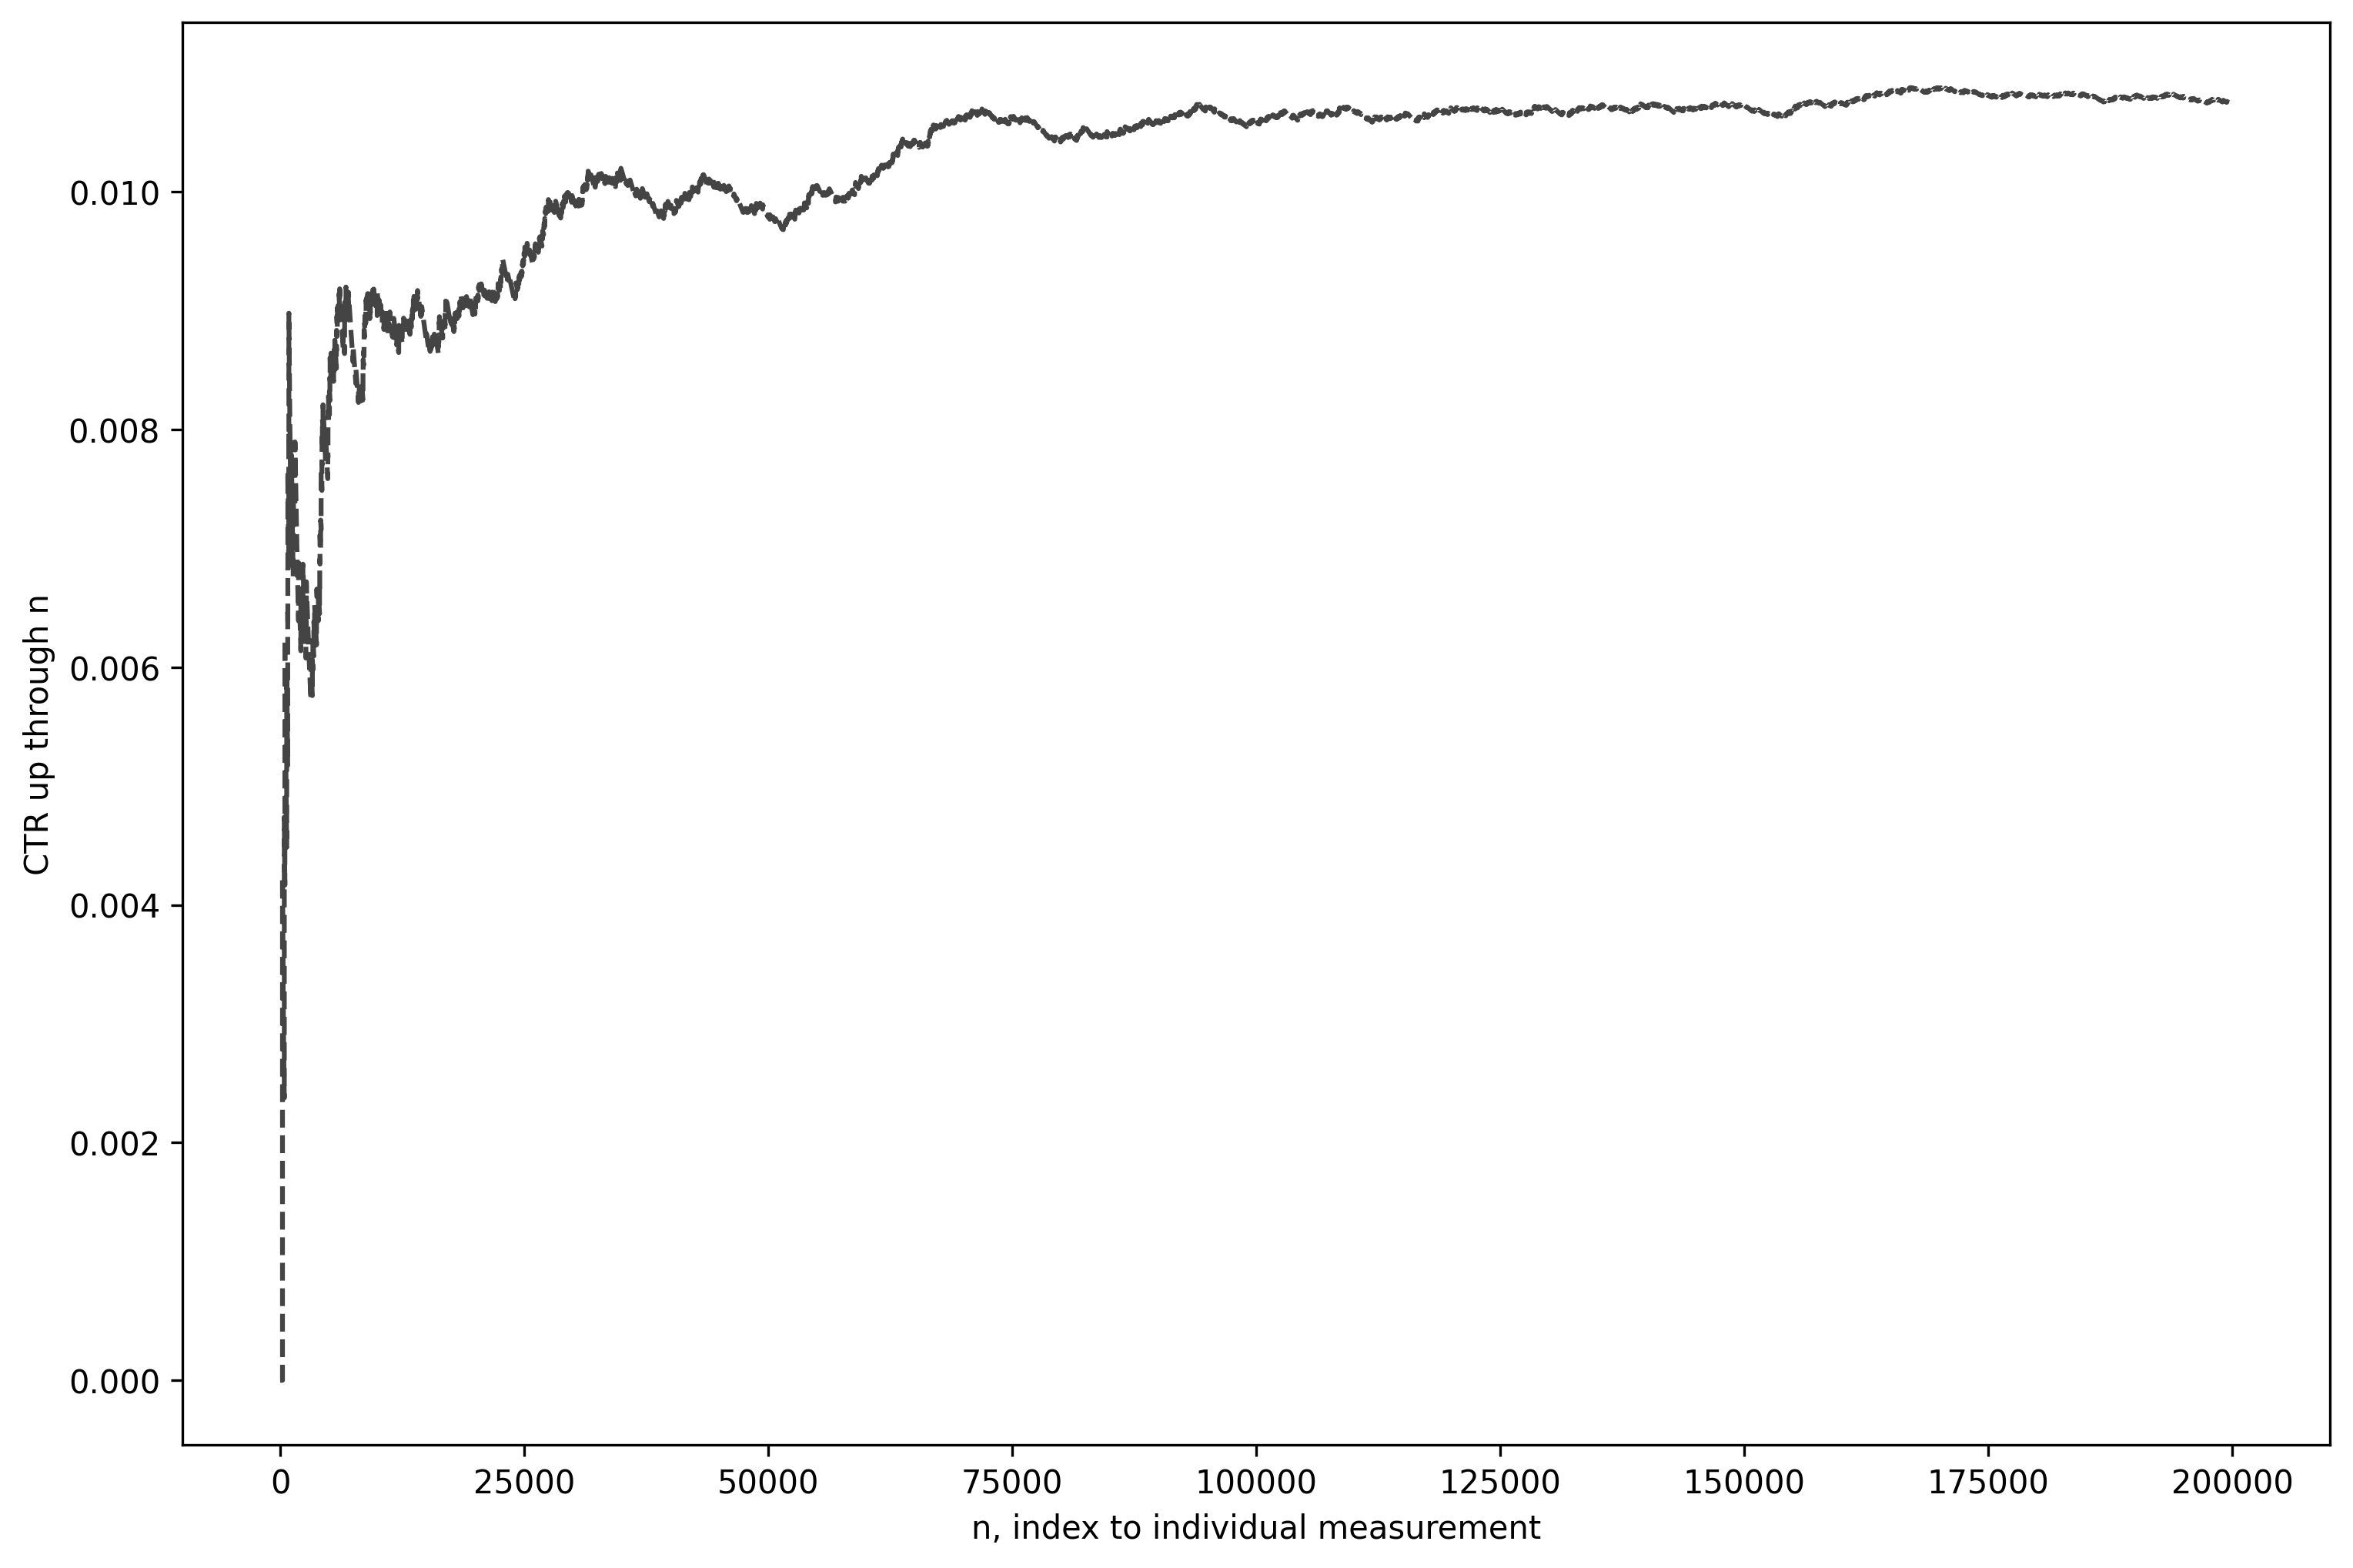

In [697]:
plt.figure(figsize=(12,8))
plt.plot(ctr_epsilon_greedy_decay_multi, '--', color=e4e.color_1)
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n')
plt.show()

In [698]:
indices_multi, rate_selected_multi = run_multi_selection_rate(lambda: epsilon_greedy_decay_multi()[-1],100)
print(indices_multi)

[0 1 2 3]


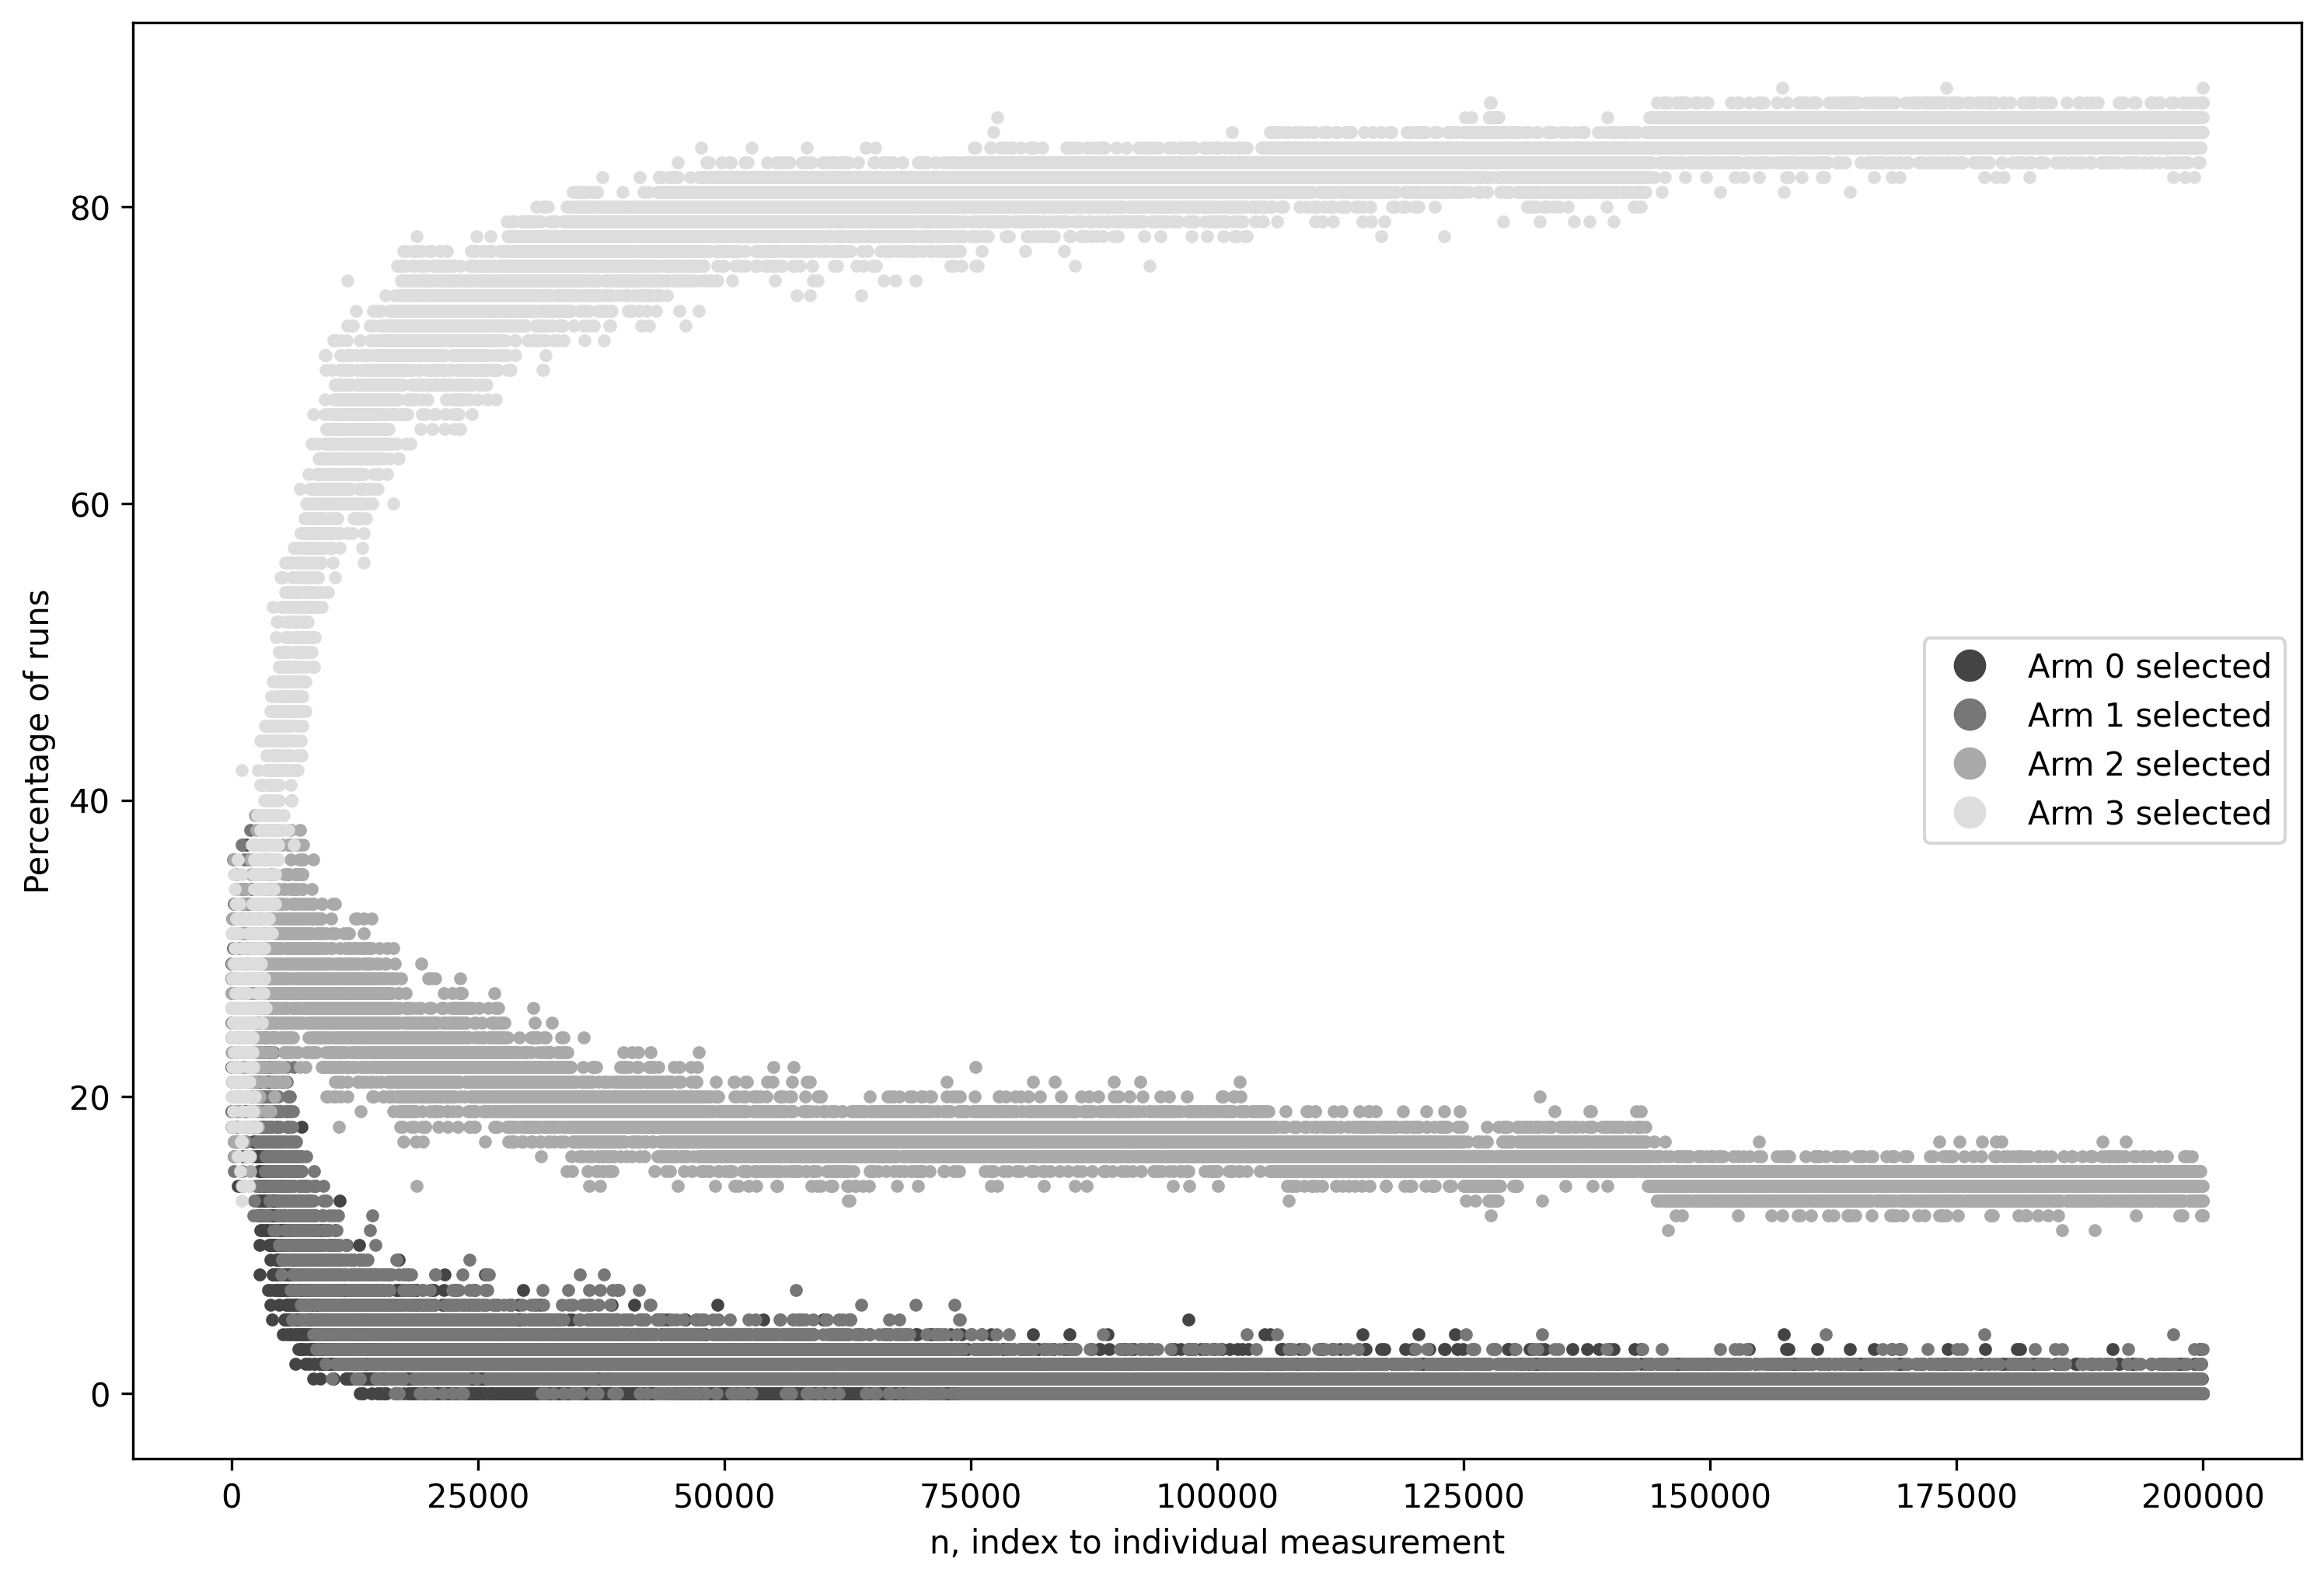

In [699]:
plt.figure(figsize=(12,8))
n = np.arange(rate_selected_multi.shape[1])[::10]
legend = []
for i in range(4):
    plt.plot(n, 100*rate_selected_multi[i,::10], '.', color=e4e.colors[i])
    legend.append(f"Arm {i} selected")
plt.legend(legend, markerscale=3)
plt.ylabel("Percentage of runs")
plt.xlabel('n, index to individual measurement')
plt.show()

### Thompson sampling: A more efficient MAB algorithm

The $c$ parameter in epsilon-greedy is controls the initial exploration and the stopping time. This is a system-dependent metaparameter. Another solution to the multi-armed bandit problem, is the thompson sampling and randomized probability matching. Epsilon-greedy chooses the best arm with a probability of P(1-epsilon), but chooses the rest randomly and i believe uniformly. Thompson sampling chooses each arm with a probability that matches the probabilty of being the best arm. That is, the choice of which arm to measure is randomized (exploration) but the best arm is chosen more often (exploitation). The algorithm stops when the probability of being the best arm reaches a threshold probability for one of the arms. $p_{stop}$, is the metaparameter that replaces $c$, but unlike $c$, its not system dependent and doesnt require trial and error to set. If we run say 100 experiments, then for each arm, we can count the number of experiments, where it was the best arm and use it to determine the probability of being the best arm. But of course, it would be ideal to have a way of calculating this probability that doesnt rely on many experiments, but rather uses one experiment. The bootstrap allows us to use one set of individual measurements to estimate the probability of being the best arm, just like how the standard error allows us to estimate the standard deviation of an aggregate measurement without taking many aggregate measurements.

$p_{measure}(arm)$ = $p_{best}(arm)$

$p_{best}(arm)$  = $\frac{\#\;of\;experiments\;where\;arm\;was\;best}{\#\;of\;experiments}$





In [700]:
I_clicked = np.array([0,0,1,0,1,1,0,0,1,0])         # individual measurements (clicked or not boolean)
CTR = I_clicked.mean()                              # aggregate measurement, click through rate

SE = I_clicked.std() / np.sqrt(len(I_clicked))      # uncertainty of aggregate measurement

In [701]:
# Generate a bootstrap sample from a data set
def bootstrap_sample(data):
    n = len(data)                                           # size of data set
    return data[np.random.randint(n, size=(n,))]            # select random elements of data

In [702]:
np.random.seed(17)
print(bootstrap_sample(I_clicked))
print(bootstrap_sample(I_clicked))
print(bootstrap_sample(I_clicked))

[0 0 0 0 0 0 1 0 1 0]
[0 0 0 1 1 0 0 0 0 0]
[0 1 0 0 1 0 0 1 0 0]


In [703]:
def replicate_means(data, num_replications):
    means = []
    for _ in range(num_replications):
        means.append(bootstrap_sample(data).mean())  #bootstrap followed by aggregate 
    return np.array(means)

In [704]:
np.random.seed(17)
ctrs = replicate_means(I_clicked, 1000)
print(ctrs.mean())
print(ctrs.std())      # std of replicated data is close to standard error of single aggregate measurement

0.39829999999999993
0.15055600286936419


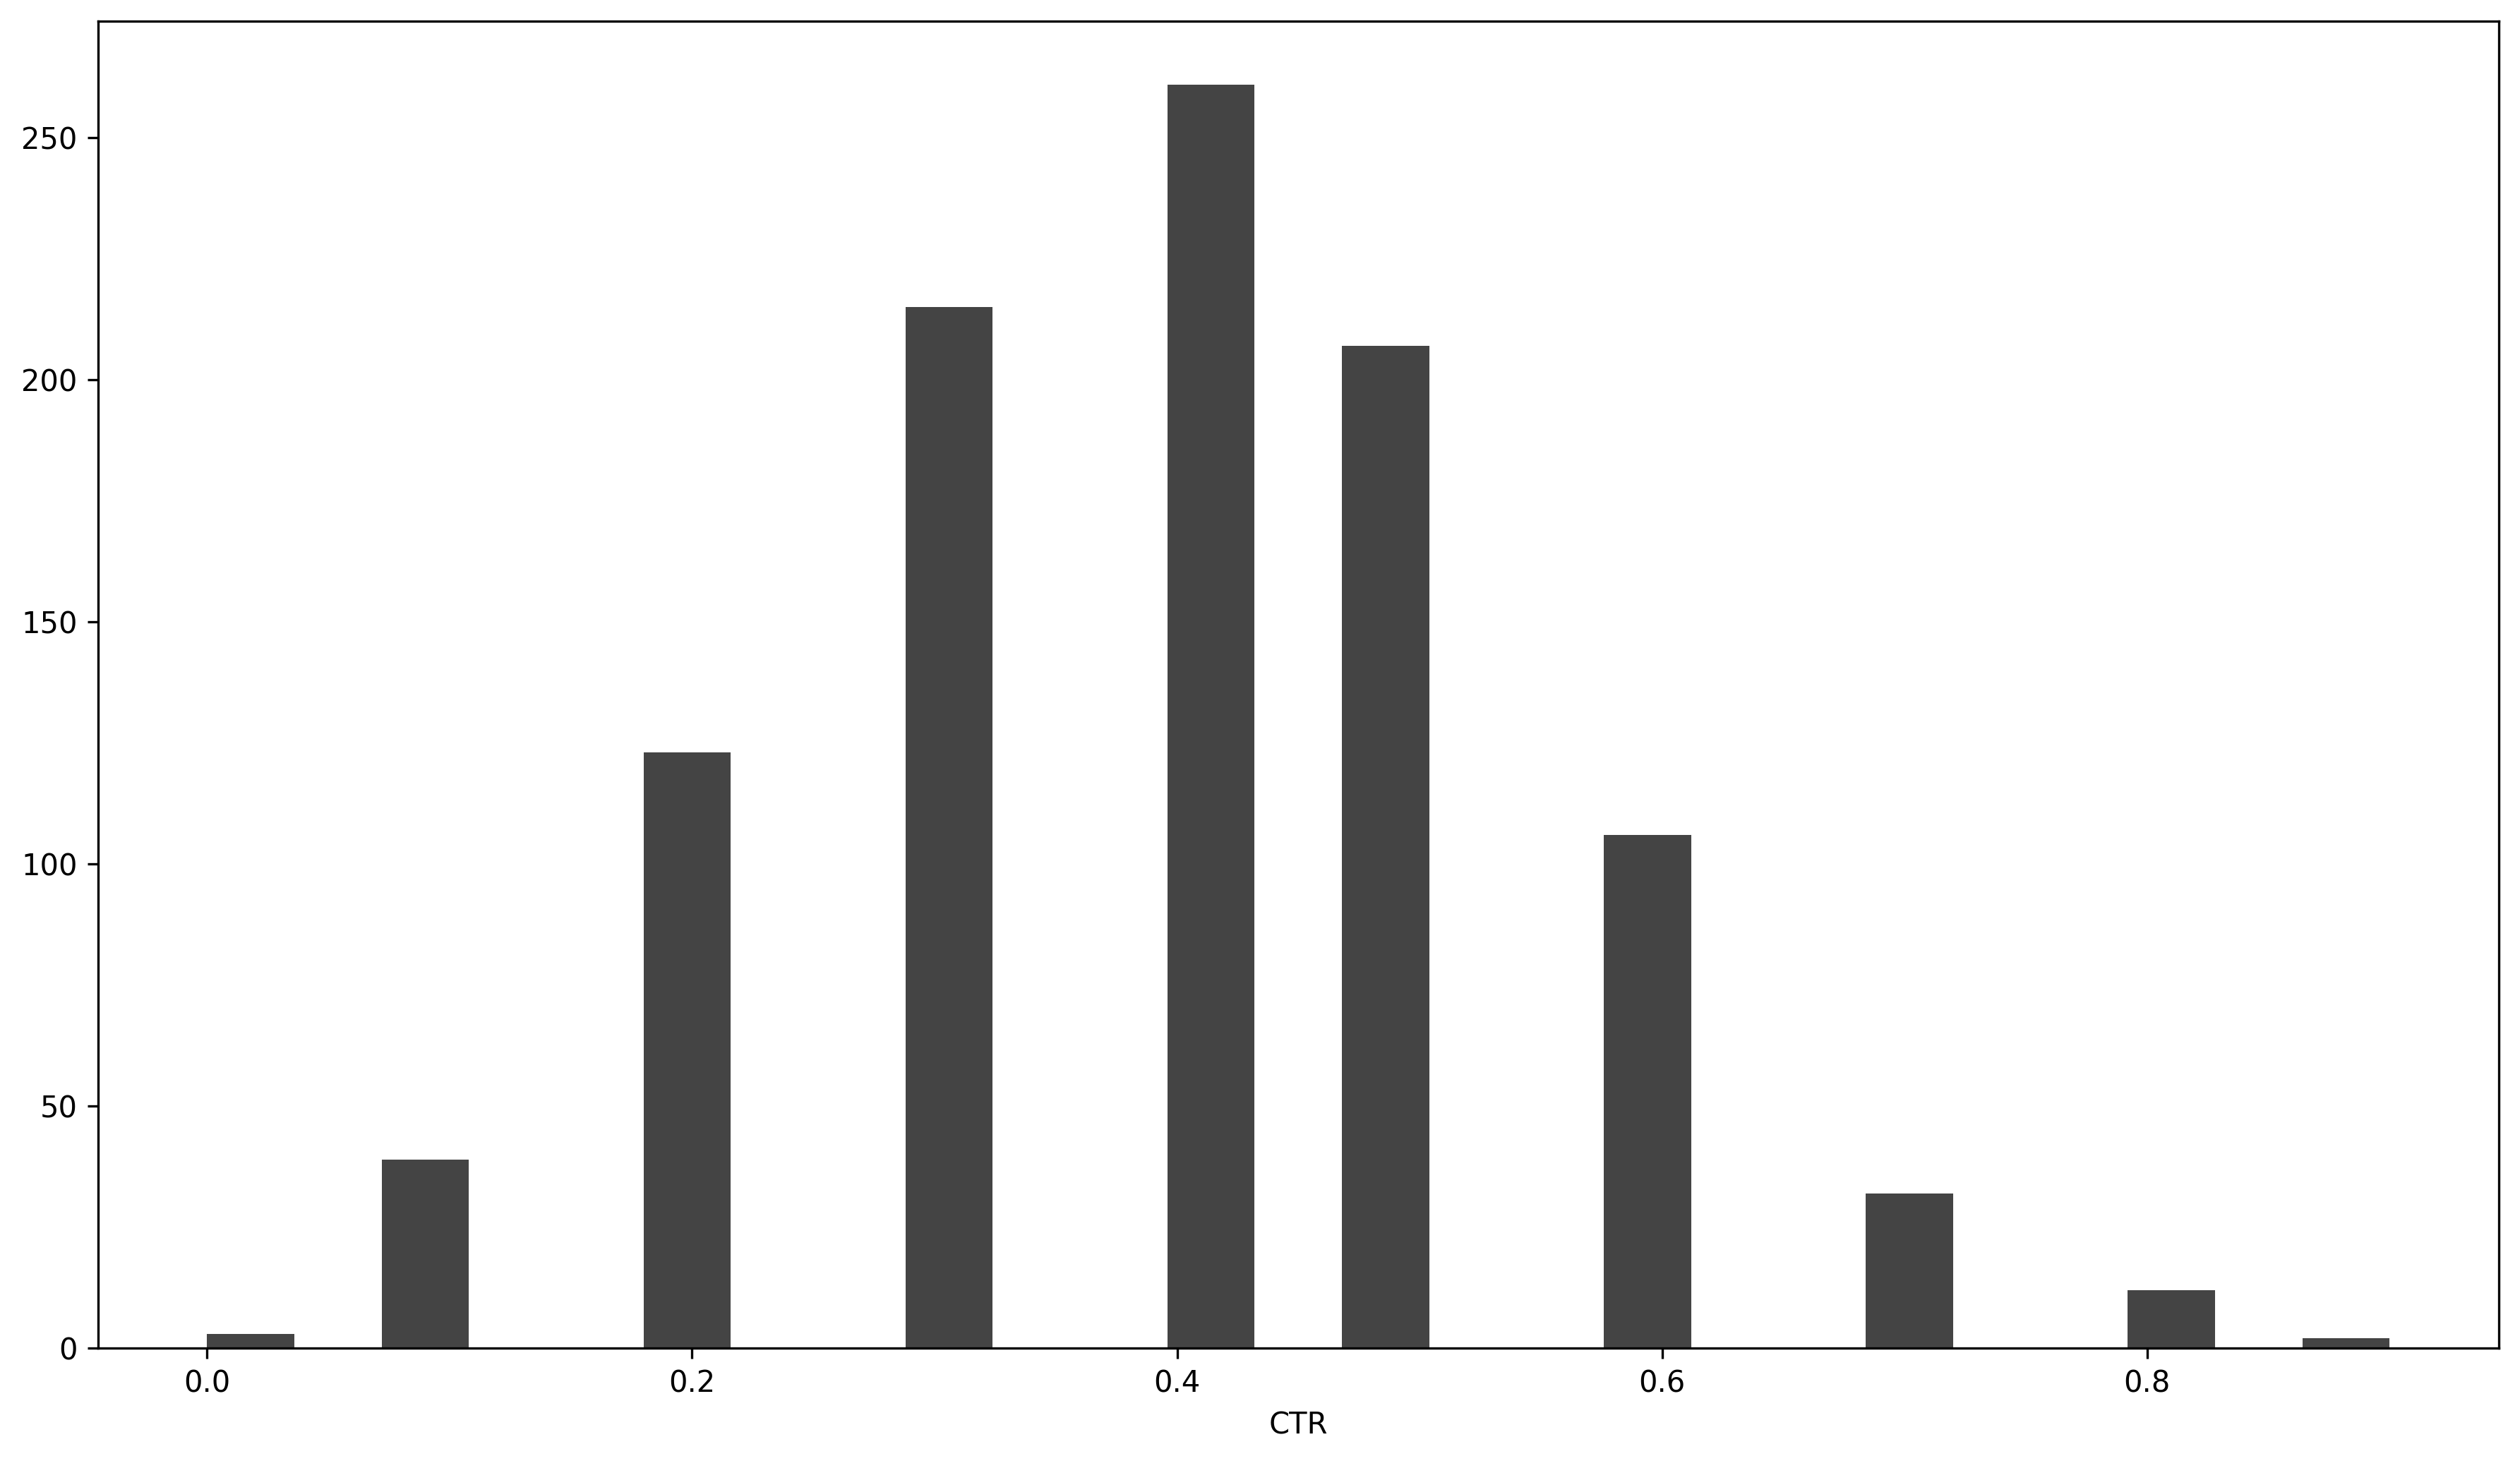

In [705]:
np.random.seed(17)
plt.figure(figsize=(12,7))
plt.hist(replicate_means(I_clicked, 1000), 25, color=e4e.color_1)
plt.xlabel('CTR')
plt.tight_layout()
plt.show()

#### Working with few individual measurements

/var/folders/35/13t91srs6wg9ml5d___c_nh40000gn/T/ipykernel_2939/3277867018.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]*len(locs))


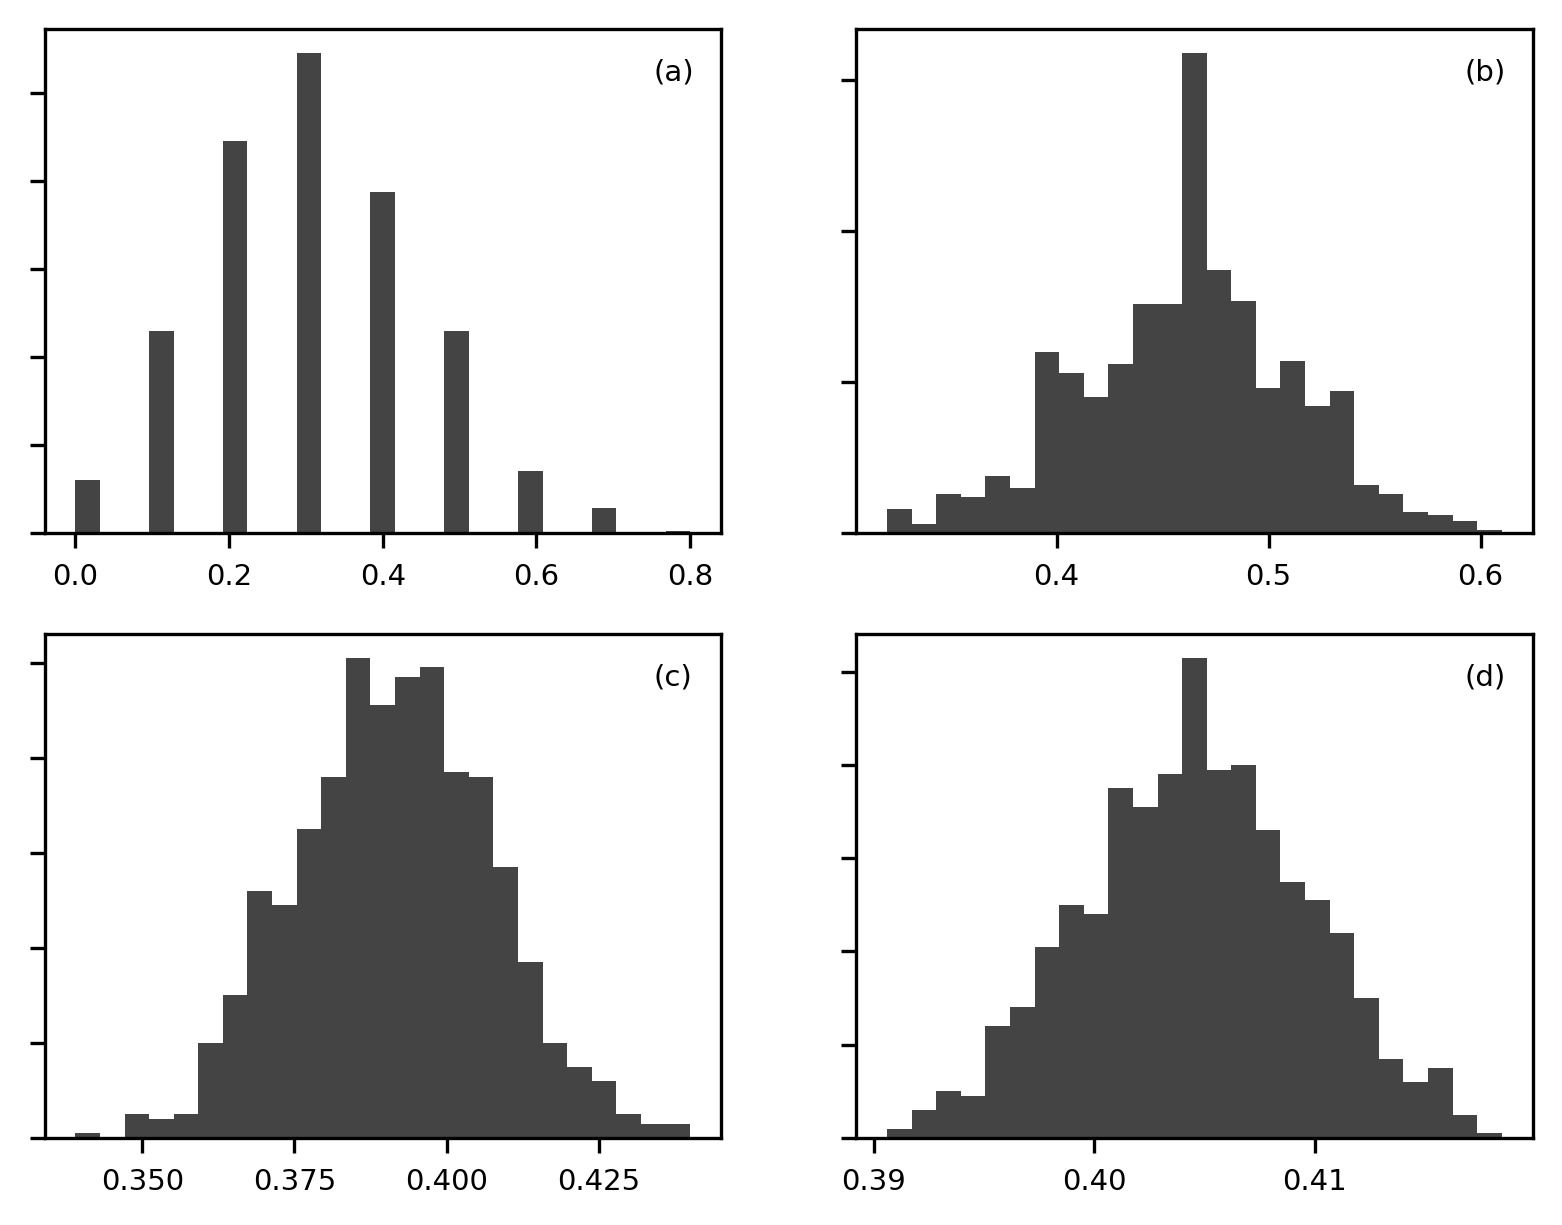

In [706]:
# Working with few individual measurements
np.random.seed(17)
fig, axs = plt.subplots(2,2)
letters = ["a", "b", "c", "d"]
num_measurements = 10
for i in range(4):
    row, col = i//2, i%2         # floor and modulus for row and column
    ax = axs[(row,col)]  
    ax
    ax.hist(replicate_means(np.random.binomial(n=1, p=.4, size=(int(num_measurements+.5,))),1000),
                             25, color=e4e.color_1)
  
    for label in ax.get_xticklabels():
        label.set_fontsize(7)               # increase font of labels on x-axis  
    locs = ax.get_yticks()                  # get y tick points
    ax.set_yticklabels([""]*len(locs))      # set y tick labels as empty strings
    num_measurements *= 10                  # increase number of measurments 10 fold, after each iteration
    c = ax.axis()                           # xmin, xmax, ymin, ymax
    ax.text(.1*c[0] + 0.90*c[1], .1*c[2] + .9*c[3], f"({letters[i]})", fontsize=7) # label subplot
plt.show()

#### Probability of being the Best Arm

In [707]:
np.random.seed(17)
I_clicked_1 = np.array([measure_click(ctr=.005) for _ in range(10000)]) # 10,000 measurements from arm 1
I_clicked_2 = np.array([measure_click(ctr=.007) for _ in range(10000)]) # 10,000 measurements from arm 2

In [708]:
print(I_clicked_1.mean())   # aggregate measurement of arm 1
print(I_clicked_2.mean())   # aggregate measurement of arm 2

0.0042
0.0057


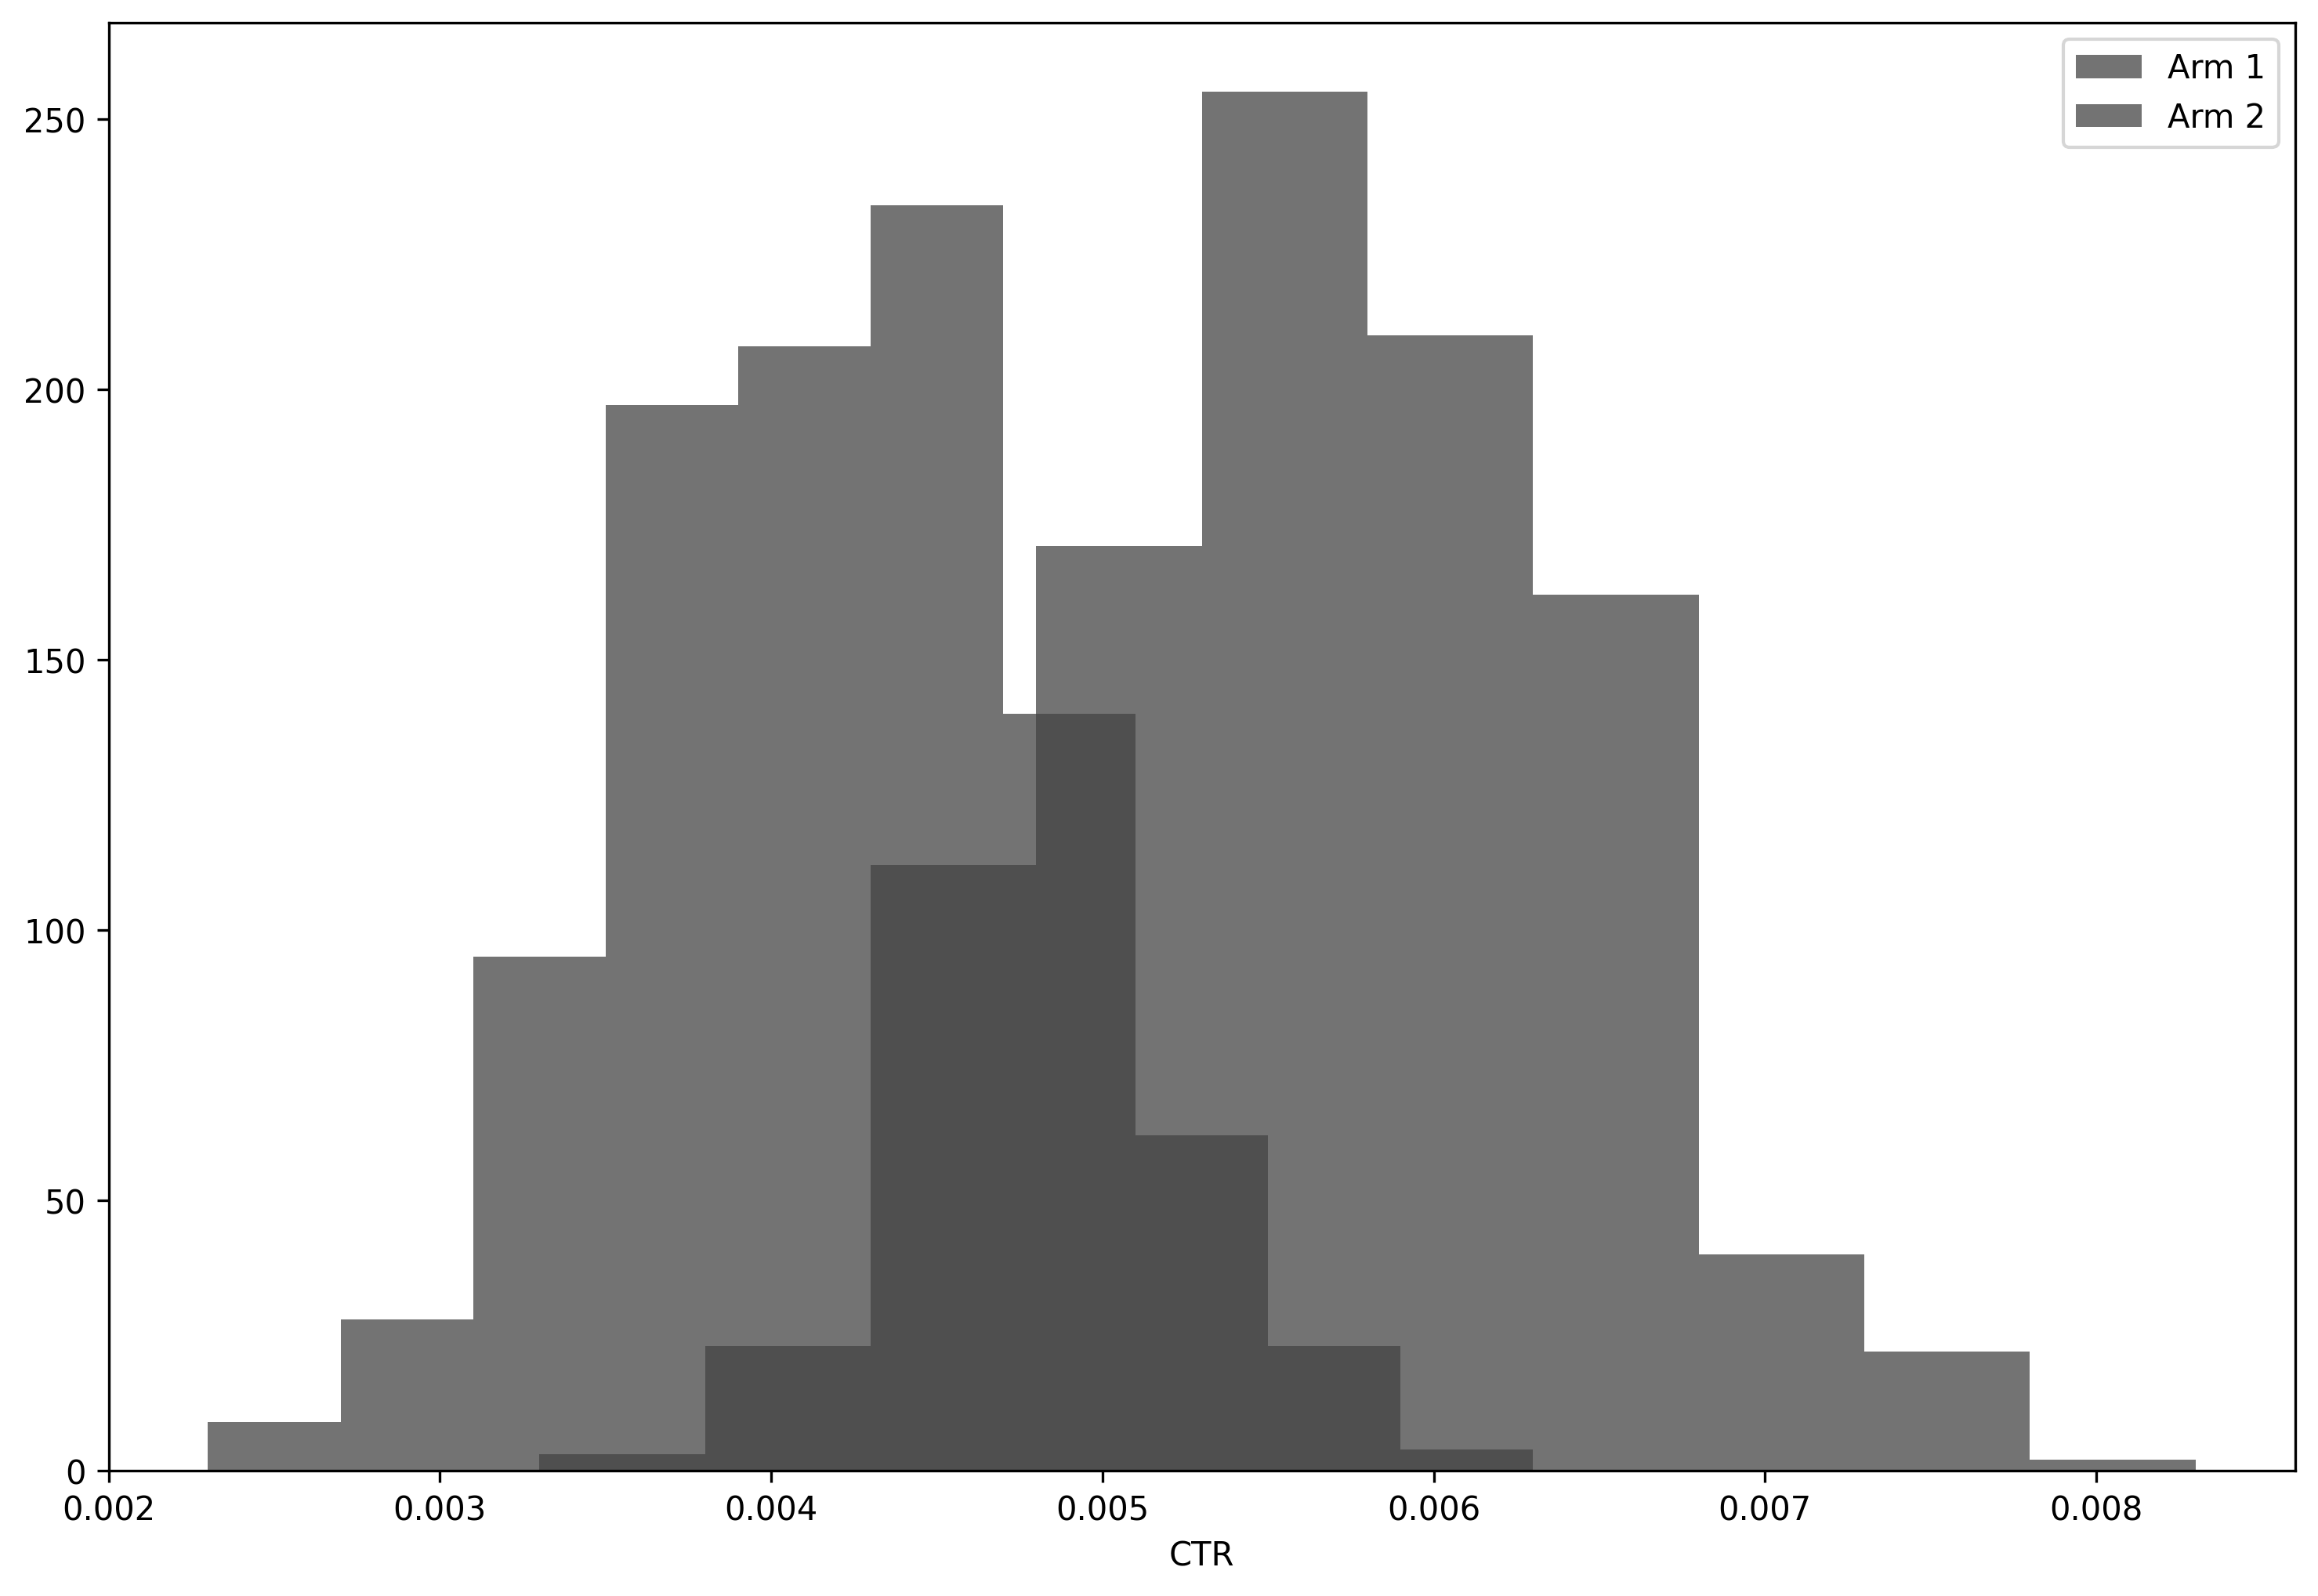

In [709]:
plt.figure(figsize=(12,8))
plt.hist(replicate_means(I_clicked_1, 1000), 10, color=e4e.color_1, alpha=.75) # bootstrap 1000 sample means 
plt.hist(replicate_means(I_clicked_2, 1000), 10, color=e4e.color_1, alpha=.75) # bootstrap 1000 sample means
plt.legend(['Arm 1', 'Arm 2'])
plt.xlabel('CTR')
plt.show()

In [710]:
# Estimate the probability of each arm being the better arm
def estimate_pbest(I_clicked_1, I_clicked_2):
    counts = [0,0]

    num_samples = 100
    for _ in range(num_samples):
        ctr_1 = bootstrap_sample(I_clicked_1).mean()    # bootstrap same-sized sample, get aggregate measurement
        ctr_2 = bootstrap_sample(I_clicked_2).mean()
        if ctr_1 > ctr_2:
            counts[0] += 1          # track number of times arm 1 has the better aggregate measurement
        elif ctr_2 > ctr_1:
            counts[1] += 1          # track number of times arm 2 has the better aggregate measurement
        else:
            pass                    # ignore cases where the aggregate measurements are equal
    p_best = np.array(counts) / num_samples     # probability of each arm being the best arm
    return p_best

In [711]:
np.random.seed(17)
estimate_pbest(I_clicked_1, I_clicked_2)

array([0.04, 0.95])

In [712]:
# Estimating the probability that each arm is the best for multiple arms
def estimate_pbest(I_clickeds):
    counts = [0]* len(I_clickeds)       # initialize counts for best arm for multiple arms
    num_samples = 100                   # 100 runs to calculate probability (can be any number)
    for _ in range(num_samples):        # each iteration, take one set of measurements
        ctrs = [bootstrap_sample(I_clicked).mean() for I_clicked in I_clickeds] # bootstrap sample ctrs for arms
        ctrs = np.array(ctrs)           # convert list of business metrics to ndarray
        i = np.where(ctrs == ctrs.max())[0] # arm with highest ctr; list of lists, so access inner list
        if len(i) == 1:     # if inner list is of length 1, means there is a clear max, no ties
            counts[i[0]] += 1   # access returned index inside ndarray to increment best count
    return np.array(counts)/num_samples         # probability that arm is the best arm

In [713]:
np.random.seed(17)
I_clickeds = [None]*4        
I_clickeds[0] = np.array([measure_click(ctr=0.03) for _ in range(1000)])   # samples from arm 1
I_clickeds[1] = np.array([measure_click(ctr=0.05) for _ in range(1000)])   # samples from arm 2
I_clickeds[2] = np.array([measure_click(ctr=0.07) for _ in range(1000)])   # samples from arm 1
I_clickeds[3] = np.array([measure_click(ctr=0.09) for _ in range(1000)])   # samples from arm 1
estimate_pbest(I_clickeds)

array([0.  , 0.  , 0.02, 0.98])

#### Randomized Probability Matching

Randomized probability matching uses bootstrapping to choose which arm to measure next. Basically, instead of calculating the $p_{best}(arm)$, bootstrapping is used to simulate one sample from individual measurements, aggregate measure calculated for each arm, and which ever arm has the best aggregate measurement is chosen for the next measurement. With that said, every time a decision is made, bootstrapping is used to simulate a sample from all the collected data. This means the longer the experiment goes on, the longer the bootstrapping step will take, and since this step happens each time a decision is to be made, the complexity is on the order of $O(T^2)$ where $T$ is the number of randomization decisions (which is proportional to time).

In [714]:
# randomized probability matching using bootstrap Thompson sampling to estimate p_best(arm)
def rpm_select_arm(I_clickeds):
    ctrs = [bootstrap_sample(I_clicked).mean() for I_clicked in I_clickeds] # bootstrap sample ctr for each arm
    ctrs = np.array(ctrs)                           # convert list to ndarray
    i = np.where(ctrs == ctrs.max())[0]             # measure arm with highest estimated CTR
    if len(i) != 1:                         # if more than one arm have the highest estimated business metric
        return np.random.randint(len(I_clickeds))   # choose randomly
    return i[0]                             # otherwise return the arm with highest estimated business metric

#### Online Bootstrap

Bootstrapping for randomized probability runs slower and slower, with each randomization decision. An improvement is to construct an incremental bootstrap sampler that doesnt need to access the entire set of collected measurements but rather just the last measurement. In fact we can choose to track $B$ bootstrap samples instead of the single last measurement, moving the time complexity from $O(T^2)$ to $O(TB)$. 

Track a fixed number (num_bs_means) of buckets of incremental bootstrap means for each arm. When we need to get the $p_{best}(arm)$ for each arm, we randomly pick a bucket mean (online bootstrap) repeatedly and calculate $p_{best}(arm)$. 

For any single arm, we dont actually store the data inside the buckets; we simply track total clicks and the total ads in each bucket. When we use a particular arm to send an ad to a user, we store the result by randomly choosing half of the num_bs_means buckets of that arm and updating the click and ad totals of that buckets with the user result. That is, with probability 0.5 we add each new measurement to a running sum. To know the bootstrap mean of a bucket, just divide the sum by the number of measurements added so far. How do we know that we have enough measurements to detect the $prac_sig$ difference we want. The smallest difference between between two samples, divided by the number of samples collected so far in each arm, must be equal to or less than the $prac_sig$. In the example here, a single click is the smallest detectable difference.

$prac_{sig}=\frac{smallest\_difference}{n}$


$n=\frac{smallest\_difference}{prac_{sig}}$

$n=\frac{1}{prac_{sig}}$

We dont calculate the randomized probability matching $p_{best}$ everytime; rather we do it occassionally. Below, we do that whenever all arms have reached a minimum number of ads served, and we are on an iteration thats divisible by 100. To establish $p_{best}$, we randomly choose buckets for each arm, check which arm's bucket has the highest business metric. We do this 100 times, counting the number of times each arm's bucket had the highest businees metric. After that we convert this count to a probability. If the $p_best$ has reached a threshold of $p_{stop}$, its time to stop the algorithm.

In [715]:
class OnlineBootstrap:
    def __init__(self, num_bs_means):       # each arm will track statitics of num_bs_means samples (buckets)
        self._sums = np.zeros(shape=(num_bs_means,))    # track sum of clicks for each bootstrap bucket of arm
        self._n = np.zeros(shape=(num_bs_means,))       # track number of ads for each bootstrap bucket of arm
        self._count = 0                 # total number of ads served by arm for all bootstrap buckets
    
    def append(self, clicked):
        i = np.where(np.random.randint(2, size=(len(self._n,))) == 0)[0] # randomly pick about half the buckets
        self._sums[i] += clicked        # store user result, clicked or not, in chosen buckets
        self._n[i] += 1                 # increment number of ads served for chosen buckets
        self._count += 1                # increment total number of times arm is chosen to serve ad

    def CTR_estimate(self):
        i = np.random.randint(len(self._n))             # choose one of the CTRs at random
        if self._n[i] == 0:             # if the specific CTR bootstrap has no samples
            return np.inf    # Induce measurement of this arm when no data has been collected yet (max comp)
        return self._sums[i] / self._n[i]              # estimate business metric for chosen bucket 
    
    def count(self):                    # returns the number of times arm was chosen to serve ads
        return self._count

In [716]:
# Randomized probability matching with the online bootstrap
def rpm_select_arm_ob(obs):
    ctrs = [ob.CTR_estimate() for ob in obs]    # business metric for a random bucket of each arm
    ctrs = np.array(ctrs)
    i = np.where(ctrs == ctrs.max())[0]  # if particular object has no data, np.inf makes it the chosen one
    return np.random.choice(i)    # randomize among arms tied for best CTR, or just return best arm if only one

In [717]:
# Estimate pbest with the online bootstrap
def estimate_pbest_ob(obs):
    counts = [0] * len(obs)                         # initialize data structure for counts and ctrs
    num_samples = 100   
    for _ in range(num_samples):                
        ctrs = [ob.CTR_estimate() for ob in obs]    # OnlineBootstrap provides a CTR estimate for each arm
        ctrs = np.array(ctrs)
        i = np.where(ctrs == ctrs.max())[0]
        if len(i) == 1:                             # Ignore cases where multiple arms are tied for best   
            counts[i[0]] += 1                       # increament number of times arm is best
    return np.array(counts)/num_samples

In [718]:
# Thompson sampling
def thompson_sampling():
    k = 4                                   # number of arms
    num_bs_means = 100                      # number of bootstrap means (buckets) tracked for each arm
    p_stop = 0.95                           # when p_best(arm) reaches p_stop for any arm, we stop algorithm
    smallest_sum_difference = 1             # one user click enough to differentiate two arms
    prac_sig = 0.001                        # business metric change we want to measure

    min_samples_per_arm = smallest_sum_difference / prac_sig    # min samples to avoid discretization error
    obs = [OnlineBootstrap(num_bs_means) for _ in range(k)]     # initialize online boosting for each arm 
    sum_clicks = 0.0                                            # total number of clicked ads
    num_ads = 0.0                                               # total number of ads served
    ctr_vs_n = []                                               # overall business metric per iteration

    n = 0                                                       # initialize iteration number
    
    # choice of arm for measurement is based on ctr estimates; stopping is based on p_best(arm)
    while True:
        num_samples_per_arm = [ob.count() for ob in obs]    # number of online bootstrap samples for each arm
        i_too_few = np.where(np.array(num_samples_per_arm) < min_samples_per_arm)[0] # enough ads served 
        if len(i_too_few) > 0:  # if any arm doesnt has less than min sample number for discretization error 
            i_selected = np.random.choice(i_too_few)    # select arm randomly aka explore until min sample
        else:                       # if all arms have min sample number
            i_selected = rpm_select_arm_ob(obs)     # choose arm with best estimate of business metric (ctr)

        i_clicked = measure_arm(i_selected)         # run the chosen arm (i_selected is an integer)
        obs[i_selected].append(i_clicked)           # store the result of clicking said arm
        sum_clicks += i_clicked                     # track total clicked by users
        num_ads += 1                                # total ads served to users
        ctr_vs_n.append(sum_clicks / num_ads)       # track overall ctr per iteration

        n += 1                                      # increment number of iterations
        if len(i_too_few) == 0 and n % 100 == 0:    # arms have min samples, check estimate_pbest occassionally
            p_bests = estimate_pbest_ob(obs)    # get ctr for each arm using one of their num_bs_means samples
            i_best_arm = np.where(p_bests == p_bests.max())[0]  # get the arm with the p_best(arm)
            if len(i_best_arm) == 1 and p_bests.max() >= p_stop:    # stop if singular p_best(arm) exceeds pstop
                break 
    return ctr_vs_n, i_best_arm

In [719]:
np.random.seed(17)
ctr_ts, i_best_arm = thompson_sampling()
print(len(ctr_ts), ctr_ts[-1], i_best_arm)

6800 0.00926470588235294 [3]


In [720]:
# number of times the best arm is selected (1 - mean_selected = false positive / negative rate)
np.random.seed(17)
mean_selected, std_selected = run_multi(lambda: [thompson_sampling()[1]==3], 100)
print(mean_selected, std_selected)

[[0.96]] [[0.19595918]]


In [721]:
# Average and maximum number of iterations 
def run_multi_count(trace_fn, num=100):
    nums = []
    for _ in range(num):
        trace = trace_fn()
        nums.append(len(trace))

    nums = np.array(nums)
    return nums.mean(), nums.max()

In [722]:
# the average / maximum number iteration taken by thompson sampling to reach p_stop
np.random.seed(17)
nums_mean, nums_max = run_multi_count(lambda: thompson_sampling()[0],100)
print(nums_mean, nums_max)

20616.0 103500


In [723]:
# Version of Thompson sampling for fixed iteration for comparison to epsilon-greedy and A/B testing
def thompson_sampling_compare():
    k = 4                               # number of arms (versions being tested)
    num_bs_means = 100                  # number of bootstrap buckets to keep for each arm
    p_stop = 0.95                       # if p_best(arm) for any arm exceeds threshold, arm is accepted arm
    smallest_sum_difference = 1         # smallest difference between two arms' sum results
    prac_sig = 0.001                    # practical significance of business metric (ctr)

    min_samples_per_arm = smallest_sum_difference / prac_sig    # minimum samples to avoid discretization error

    obs = [OnlineBootstrap(num_bs_means) for _ in range(k)]     # intialize online bootstrapping object for arms
    sum_clicks = 0.0                    # total number of clicks by users (for overall ctr)
    num_ads = 0.0                       # total number of ads served to users (for overall ctr)
    ctr_vs_n = []                       # business metric versus iteration
    i_best_arm = None                   # first arm to reach p_stop

    n = 0                               # initialize iteration number
    accepted = False                    # a version has been accepted when p_stop is reached by an arm
    for _ in range(200000):             # fixed number iteration for comparison with other algorithms
        # select arm for next measurement
        if accepted:                    # if the best arm has already been found
            i_selected = i_best_arm     # choose the best arm for measurement (exploitation)
        else:                           
            num_samples_per_arm = [ob.count() for ob in obs] # get the ad count served by each model
            i_too_few = np.where(np.array(num_samples_per_arm) < 
                                 min_samples_per_arm)[0] # arms without min ad served size for discretization
            if len(i_too_few) > 0:      # if some arms don't have min ad served
                i_selected = np.random.choice(i_too_few)    # explore arms without min ad served
            else:                       # if all arms have min ad served
                i_selected = rpm_select_arm_ob(obs)     # exploit with highest estimated business metric arm

        # make next measurement with selected arm
        i_clicked = measure_arm(i_selected)     # serve ad with selected arm and return user response
        obs[i_clicked].append(i_clicked)        # update half of selected arm's buckets with user response
        sum_clicks += i_clicked                 # update total number of clicks with user response
        num_ads += 1                            # update total number of ads with user response
        ctr_vs_n.append(sum_clicks / num_ads)   # store businees metric for this iteration

        n += 1                                  # increment iteration number

        # estimate p_best(arm) and accepted arm
        if not accepted and len(i_too_few) == 0 and n % 100 == 0: # no arm accepted, min ads met, on occassion
            p_bests = estimate_pbest_ob(obs)    # estimate probability of each arm being the best arm
            i_best_arm = np.where(p_bests == p_bests.max())[0]      # arms with most top ctr 
            if len(i_best_arm) == 1 and p_bests.max() >= p_stop: # if only one arm is top and reaches p_stop
                i_best_arm = i_best_arm[0]  # the top arm is the best arm
                accepted = True             # found a top solution among arms
                print('ay')                 # lol
    return ctr_vs_n, i_best_arm             # overall ctr of experimentation period, and best arm (integer)

In [724]:
np.random.seed(17)
mean_ts_compare, std_ts_compare = run_multi(lambda: thompson_sampling_compare()[0], 100)
print(mean_ts_compare[-1], std_ts_compare[-1])

0.00947165 0.00023752584596207628


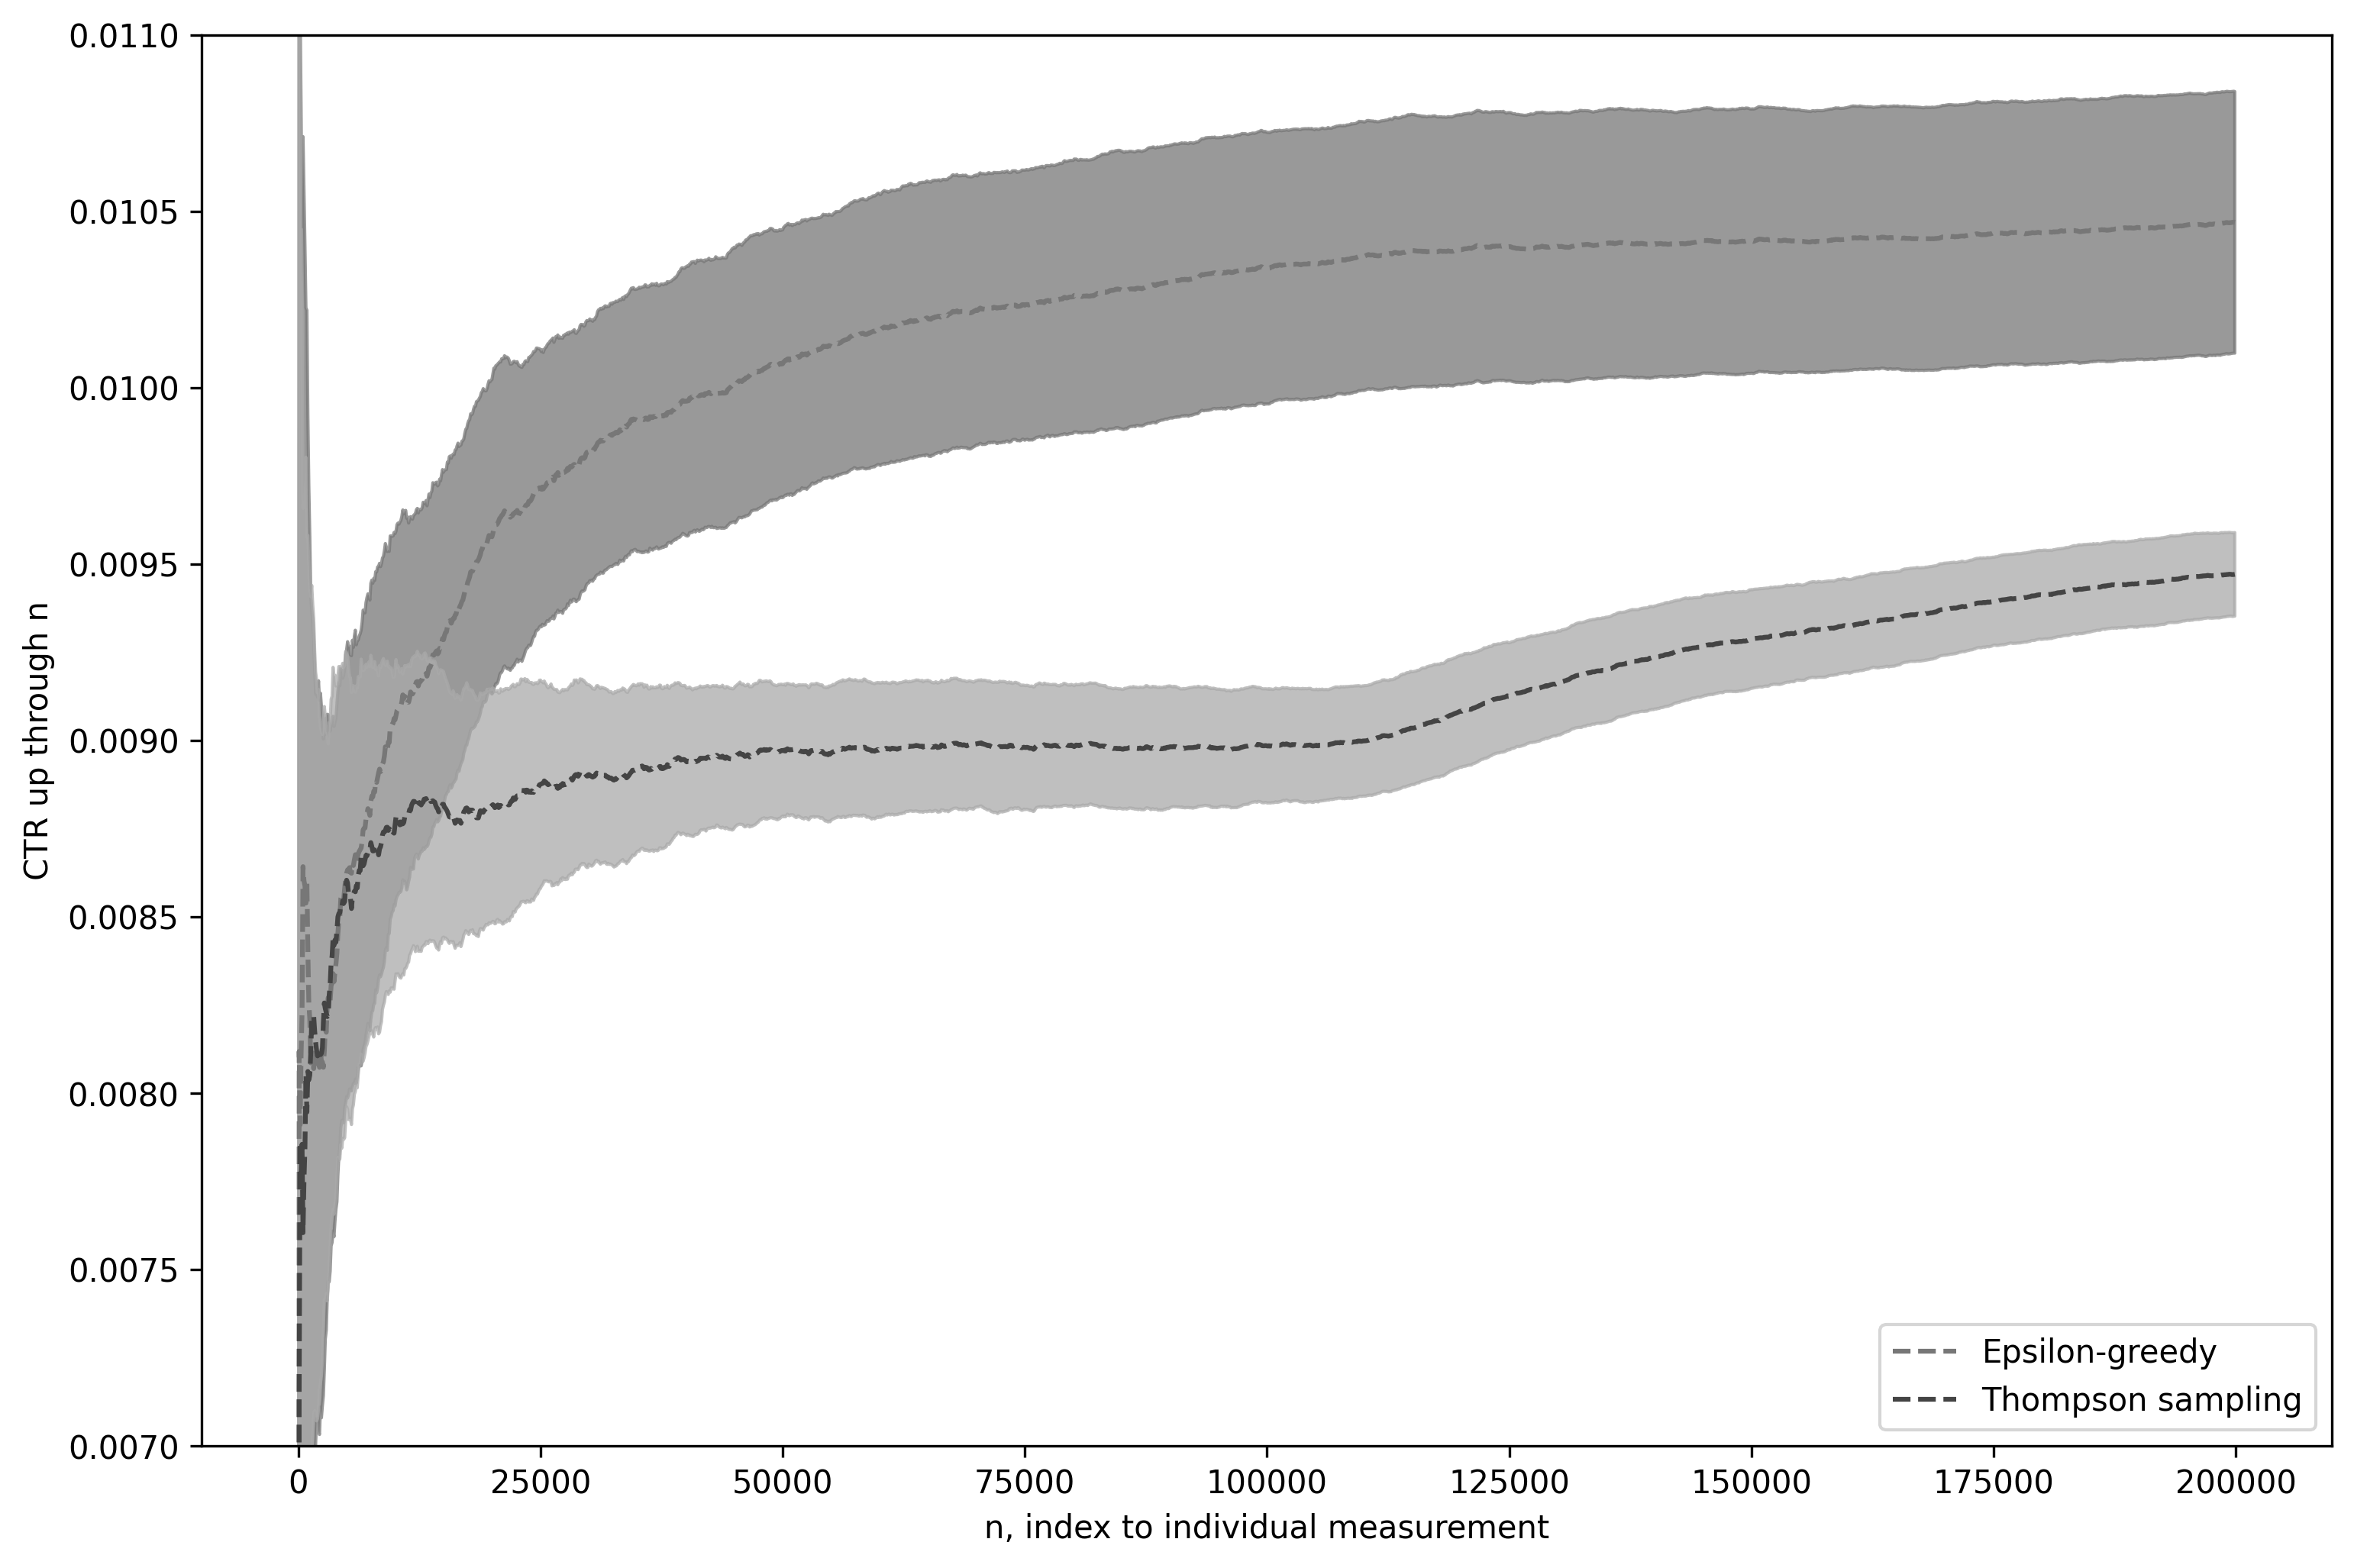

In [729]:
mean_egd_tr = mean_egd          # mean experimentation business metric trace of epsilon greedy decay
std_egd_tr = std_egd            # standard error of mean business metric trace of epsilon greedy decay

mean_ts_tr = mean_ts_compare    # mean experimentation business metric trace of thompson sampling
std_ts_tr = std_ts_compare      # standard error of mean business metric trace of thompson sampling

n = np.arange(len(mean_egd_tr))[::100]   # choose some of the available data for plotting

plt.figure(figsize=(12,8))
plt.fill_between(n,
                 (mean_egd_tr - std_egd_tr/2)[::100],
                 (mean_egd_tr + std_egd_tr/2)[::100],
                 color=e4e.color_2, alpha=0.75, linewidth=1)

plt.plot(n, mean_egd_tr[::100], '--', color=e4e.color_2, label='Epsilon-greedy')
 
nts = np.arange(len(mean_ts_tr))[::100]
plt.fill_between(nts,
                 (mean_ts_tr - std_ts_tr/2)[::100],
                 (mean_ts_tr + std_ts_tr/2)[::100],
                 color=e4e.color_3, alpha=0.75, linewidth=1)

plt.plot(nts, mean_ts_tr[::100], '--', color=e4e.color_1, label='Thompson sampling')


c = plt.axis()
plt.xlabel('n, index to individual measurement')
plt.ylabel('CTR up through n')
plt.legend(loc='lower right')
plt.axis([c[0], c[1], 0.007, 0.011])
plt.show()


In [730]:
pd.DataFrame({'Algorithm': ['epsilon_greedy_decay()', 'thompson_sampling()'],
              'Mean_CTR': [mean_egd_tr[-1], mean_ts_tr[-1]],
              'Std. Dev. CTR': [std_egd_tr[-1], std_ts_tr[-1]]})

,Algorithm,Mean_CTR,Std. Dev. CTR
0,epsilon_greedy_decay(),0.010469,0.000742
1,thompson_sampling(),0.009472,0.000238
